## CMPINF 2100 FINAL PROJECT - Models: Fitting, Predictions, and Performance
### Travis Rogan
#### Pitt Athletics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.formula.api as smf

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.metrics import roc_curve

In [5]:
from sklearn.metrics import roc_auc_score

In [6]:
pitt_df = pd.read_csv('pitt_athletics_cmpinf2100_project.csv')
pitt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   accountid           3360 non-null   int64  
 1   age                 1567 non-null   float64
 2   gender              582 non-null    object 
 3   distancemiles       3360 non-null   float64
 4   direction           3360 non-null   object 
 5   peak_drivetime      2958 non-null   float64
 6   offpeak_drivetime   2996 non-null   float64
 7   season              3360 non-null   int64  
 8   purchase_month      3360 non-null   object 
 9   purchase_dow        3360 non-null   object 
 10  price_type          3360 non-null   object 
 11  price_level         3360 non-null   object 
 12  ticket_count        3360 non-null   int64  
 13  price_per_ticket    3360 non-null   float64
 14  return_next_season  3360 non-null   object 
dtypes: float64(5), int64(3), object(7)
memory usage: 393.9+

## Preparing the Data

In [7]:
pitt_df_clean = pitt_df.copy()

In [8]:
pitt_df_clean.gender.fillna(value='(UNKNOWN)',inplace=True)
pitt_df_clean.gender.value_counts()

gender
(UNKNOWN)                  2778
Male                        464
Female                      100
Prefer not to say            13
Prefer to self-describe       5
Name: count, dtype: int64

In [9]:
pitt_df_clean['gender_known'] = np.where(pitt_df_clean.gender == '(UNKNOWN)', pitt_df_clean.gender, '(KNOWN)')

In [10]:
pitt_df_clean.gender_known.value_counts()

gender_known
(UNKNOWN)    2778
(KNOWN)       582
Name: count, dtype: int64

In [11]:
pitt_df_clean['lump_ticket_count'] = np.where( pitt_df.ticket_count > 4, '5 or more', pitt_df.ticket_count.astype('str') )


In [12]:
pitt_df_clean['y'] = np.where( pitt_df.return_next_season == 'YES', 1, 0 )

In [13]:
pitt_df_clean['bin_age'] = pd.cut( pitt_df.age, bins=2, include_lowest=True, ordered=False, labels=['A', 'B'])
pitt_df_clean.bin_age = pitt_df_clean.bin_age.astype('object')
pitt_df_clean.bin_age.value_counts(dropna=False)

bin_age
NaN    1793
A      1045
B       522
Name: count, dtype: int64

In [14]:
pitt_df_clean.bin_age.fillna(value='(UNKNOWN)', inplace=True)


In [15]:
pitt_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   accountid           3360 non-null   int64  
 1   age                 1567 non-null   float64
 2   gender              3360 non-null   object 
 3   distancemiles       3360 non-null   float64
 4   direction           3360 non-null   object 
 5   peak_drivetime      2958 non-null   float64
 6   offpeak_drivetime   2996 non-null   float64
 7   season              3360 non-null   int64  
 8   purchase_month      3360 non-null   object 
 9   purchase_dow        3360 non-null   object 
 10  price_type          3360 non-null   object 
 11  price_level         3360 non-null   object 
 12  ticket_count        3360 non-null   int64  
 13  price_per_ticket    3360 non-null   float64
 14  return_next_season  3360 non-null   object 
 15  gender_known        3360 non-null   object 
 16  lump_t

In [16]:
pitt_df_clean['miles_log'] = np.log(pitt_df_clean.distancemiles)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


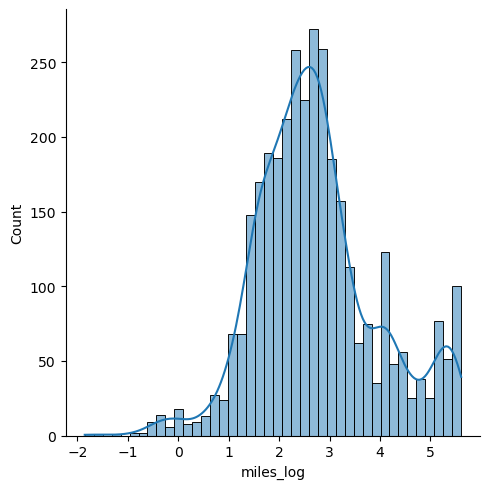

In [17]:
sns.displot(data = pitt_df_clean, x = 'miles_log', kind = 'hist', kde=True)
plt.show()

In [18]:
pitt_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   accountid           3360 non-null   int64  
 1   age                 1567 non-null   float64
 2   gender              3360 non-null   object 
 3   distancemiles       3360 non-null   float64
 4   direction           3360 non-null   object 
 5   peak_drivetime      2958 non-null   float64
 6   offpeak_drivetime   2996 non-null   float64
 7   season              3360 non-null   int64  
 8   purchase_month      3360 non-null   object 
 9   purchase_dow        3360 non-null   object 
 10  price_type          3360 non-null   object 
 11  price_level         3360 non-null   object 
 12  ticket_count        3360 non-null   int64  
 13  price_per_ticket    3360 non-null   float64
 14  return_next_season  3360 non-null   object 
 15  gender_known        3360 non-null   object 
 16  lump_t

In [19]:
columns_to_keep = ['accountid',
                   'gender_known',
                   'bin_age',
                   'direction',
                   'miles_log',
                   'purchase_month',
                   'purchase_dow',
                   'price_per_ticket',
                   'price_type',
                   'price_level',
                   'lump_ticket_count',
                   'y']
                   
                   

In [20]:
df_model = pitt_df_clean[columns_to_keep].copy()

In [21]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accountid          3360 non-null   int64  
 1   gender_known       3360 non-null   object 
 2   bin_age            3360 non-null   object 
 3   direction          3360 non-null   object 
 4   miles_log          3360 non-null   float64
 5   purchase_month     3360 non-null   object 
 6   purchase_dow       3360 non-null   object 
 7   price_per_ticket   3360 non-null   float64
 8   price_type         3360 non-null   object 
 9   price_level        3360 non-null   object 
 10  lump_ticket_count  3360 non-null   object 
 11  y                  3360 non-null   int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 315.1+ KB


## D. Fitting Models

In [22]:
formula_list = [#intercept
                'y ~ 1',
                # D.d.vi - interact categorical inputs with the continuous inputs and linear main effects
                'y ~ (gender_known + bin_age + direction + purchase_month + purchase_dow + price_type + price_level + lump_ticket_count) * (price_per_ticket + miles_log)',
                #just the continuous variables
                'y ~ miles_log + price_per_ticket',
                #All variables
                'y ~ gender_known + bin_age + direction + miles_log + purchase_month + purchase_dow + price_per_ticket + price_type + price_level + lump_ticket_count',
                #continous variables ** 2
                'y ~ (miles_log + price_per_ticket) ** 2',
                #just categorical variables
                'y ~ gender_known + bin_age + direction + purchase_month + purchase_dow + price_type + price_level + lump_ticket_count',
                # based on EDA
                'y ~ price_level + price_type + gender_known + purchase_month + bin_age',
                #Continuous with pair-wise interactions
                'y ~ miles_log * price_per_ticket',
                #Complex
                'y ~ (miles_log + price_per_ticket)**2 + np.power(miles_log, 2) + np.power(price_per_ticket, 2) * (gender_known + bin_age + direction + purchase_month + purchase_dow + price_type + price_level + lump_ticket_count)'
]
                

In [23]:
fit_0 = smf.logit(formula = formula_list[0], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4


In [24]:
fit_0.params

Intercept    0.686458
dtype: float64

In [25]:
fit_0.pvalues < 0.05

Intercept    True
dtype: bool

In [26]:
fit_1 = smf.logit(formula = formula_list[1], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.446748
         Iterations 8


In [27]:
fit_1.params

Intercept                                   2.003871
gender_known[T.(UNKNOWN)]                  -1.273016
bin_age[T.A]                               -0.425435
bin_age[T.B]                                1.667471
direction[T.N]                             -0.476553
                                              ...   
price_level[T.Upper Sideline]:miles_log    -0.234204
lump_ticket_count[T.2]:miles_log           -0.016961
lump_ticket_count[T.3]:miles_log           -0.280699
lump_ticket_count[T.4]:miles_log           -0.022330
lump_ticket_count[T.5 or more]:miles_log   -0.082607
Length: 96, dtype: float64

In [28]:
fit_1.pvalues < 0.05

Intercept                                   False
gender_known[T.(UNKNOWN)]                   False
bin_age[T.A]                                False
bin_age[T.B]                                 True
direction[T.N]                              False
                                            ...  
price_level[T.Upper Sideline]:miles_log     False
lump_ticket_count[T.2]:miles_log            False
lump_ticket_count[T.3]:miles_log            False
lump_ticket_count[T.4]:miles_log            False
lump_ticket_count[T.5 or more]:miles_log    False
Length: 96, dtype: bool

In [29]:
fit_2 = smf.logit(formula = formula_list[2], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.598729
         Iterations 5


In [30]:
fit_2.params

Intercept          -0.200182
miles_log          -0.233991
price_per_ticket    0.007132
dtype: float64

In [31]:
fit_2.pvalues < 0.05

Intercept           False
miles_log            True
price_per_ticket     True
dtype: bool

In [32]:
fit_3 = smf.logit(formula = formula_list[3], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.463606
         Iterations 7


In [33]:
fit_3.params

Intercept                            2.057229
gender_known[T.(UNKNOWN)]           -1.957519
bin_age[T.A]                         0.513583
bin_age[T.B]                         1.089826
direction[T.N]                      -0.012902
direction[T.NE]                     -0.166830
direction[T.NW]                     -0.003199
direction[T.S]                      -0.035326
direction[T.SE]                      0.008896
direction[T.SW]                     -0.205585
direction[T.W]                      -0.287821
purchase_month[T.Mar-Apr]           -0.563307
purchase_month[T.Other]             -1.744784
purchase_dow[T.Mon]                 -0.337362
purchase_dow[T.Other]               -0.229812
purchase_dow[T.Thu]                  0.028641
purchase_dow[T.Tue]                  0.215269
purchase_dow[T.Wed]                  0.274293
price_type[T.IA]                    -1.208800
price_type[T.IA-2]                  -0.289644
price_type[T.Other]                 -0.229216
price_level[T.Lower Panther Blue] 

In [34]:
fit_3.pvalues < 0.05

Intercept                             True
gender_known[T.(UNKNOWN)]             True
bin_age[T.A]                          True
bin_age[T.B]                          True
direction[T.N]                       False
direction[T.NE]                      False
direction[T.NW]                      False
direction[T.S]                       False
direction[T.SE]                      False
direction[T.SW]                      False
direction[T.W]                       False
purchase_month[T.Mar-Apr]             True
purchase_month[T.Other]               True
purchase_dow[T.Mon]                   True
purchase_dow[T.Other]                False
purchase_dow[T.Thu]                  False
purchase_dow[T.Tue]                  False
purchase_dow[T.Wed]                  False
price_type[T.IA]                      True
price_type[T.IA-2]                   False
price_type[T.Other]                  False
price_level[T.Lower Panther Blue]     True
price_level[T.Lower Panther Gold]     True
price_level

In [35]:
fit_4 = smf.logit(formula = formula_list[4], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.595660
         Iterations 6


In [36]:
fit_4.params

Intercept                     0.768504
miles_log                    -0.617700
price_per_ticket              0.002181
miles_log:price_per_ticket    0.001948
dtype: float64

In [37]:
fit_4.pvalues < 0.05

Intercept                      True
miles_log                      True
price_per_ticket              False
miles_log:price_per_ticket     True
dtype: bool

In [38]:
fit_5 = smf.logit(formula = formula_list[5], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.477232
         Iterations 7


In [39]:
fit_5.params

Intercept                            2.958718
gender_known[T.(UNKNOWN)]           -1.963606
bin_age[T.A]                         0.643572
bin_age[T.B]                         1.299247
direction[T.N]                      -0.129607
direction[T.NE]                     -0.240924
direction[T.NW]                     -0.168819
direction[T.S]                      -0.209788
direction[T.SE]                     -0.131587
direction[T.SW]                     -0.366888
direction[T.W]                      -0.595426
purchase_month[T.Mar-Apr]           -0.567591
purchase_month[T.Other]             -1.741382
purchase_dow[T.Mon]                 -0.383663
purchase_dow[T.Other]               -0.270975
purchase_dow[T.Thu]                 -0.001366
purchase_dow[T.Tue]                  0.208360
purchase_dow[T.Wed]                  0.135849
price_type[T.IA]                    -1.170182
price_type[T.IA-2]                  -0.179989
price_type[T.Other]                 -0.308164
price_level[T.Lower Panther Blue] 

In [40]:
fit_5.pvalues < 0.05

Intercept                             True
gender_known[T.(UNKNOWN)]             True
bin_age[T.A]                          True
bin_age[T.B]                          True
direction[T.N]                       False
direction[T.NE]                      False
direction[T.NW]                      False
direction[T.S]                       False
direction[T.SE]                      False
direction[T.SW]                      False
direction[T.W]                        True
purchase_month[T.Mar-Apr]             True
purchase_month[T.Other]               True
purchase_dow[T.Mon]                   True
purchase_dow[T.Other]                False
purchase_dow[T.Thu]                  False
purchase_dow[T.Tue]                  False
purchase_dow[T.Wed]                  False
price_type[T.IA]                      True
price_type[T.IA-2]                   False
price_type[T.Other]                   True
price_level[T.Lower Panther Blue]     True
price_level[T.Lower Panther Gold]     True
price_level

In [41]:
fit_6 = smf.logit(formula = formula_list[6], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.487048
         Iterations 7


In [42]:
fit_6.params

Intercept                            2.750898
price_level[T.Lower Panther Blue]    0.779987
price_level[T.Lower Panther Gold]    1.389455
price_level[T.Lower Panther Red]     0.678802
price_level[T.Lower Sideline]        0.434935
price_level[T.Other]                -0.161546
price_level[T.Upper Corners]        -0.539837
price_level[T.Upper Sideline]       -0.291241
price_type[T.IA]                    -1.246968
price_type[T.IA-2]                  -0.179164
price_type[T.Other]                 -0.327356
gender_known[T.(UNKNOWN)]           -2.018553
purchase_month[T.Mar-Apr]           -0.470013
purchase_month[T.Other]             -1.670339
bin_age[T.A]                         0.605622
bin_age[T.B]                         1.264095
dtype: float64

In [43]:
fit_6.pvalues < 0.05

Intercept                             True
price_level[T.Lower Panther Blue]     True
price_level[T.Lower Panther Gold]     True
price_level[T.Lower Panther Red]      True
price_level[T.Lower Sideline]         True
price_level[T.Other]                 False
price_level[T.Upper Corners]          True
price_level[T.Upper Sideline]        False
price_type[T.IA]                      True
price_type[T.IA-2]                   False
price_type[T.Other]                   True
gender_known[T.(UNKNOWN)]             True
purchase_month[T.Mar-Apr]             True
purchase_month[T.Other]               True
bin_age[T.A]                          True
bin_age[T.B]                          True
dtype: bool

In [44]:
fit_7 = smf.logit(formula = formula_list[7], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.595660
         Iterations 6


In [45]:
fit_7.params

Intercept                     0.768504
miles_log                    -0.617700
price_per_ticket              0.002181
miles_log:price_per_ticket    0.001948
dtype: float64

In [46]:
fit_7.pvalues < 0.05

Intercept                      True
miles_log                      True
price_per_ticket              False
miles_log:price_per_ticket     True
dtype: bool

In [47]:
fit_8 = smf.logit(formula = formula_list[8], data = df_model).fit()

Optimization terminated successfully.
         Current function value: 0.450918
         Iterations 8


In [48]:
fit_8.params

Intercept                                                       2.019520e+00
gender_known[T.(UNKNOWN)]                                      -1.956070e+00
bin_age[T.A]                                                    4.365182e-01
bin_age[T.B]                                                    1.474829e+00
direction[T.N]                                                  5.418877e-01
                                                                    ...     
np.power(price_per_ticket, 2):price_level[T.Upper Sideline]     1.086660e-05
np.power(price_per_ticket, 2):lump_ticket_count[T.2]           -6.191316e-06
np.power(price_per_ticket, 2):lump_ticket_count[T.3]           -1.080507e-05
np.power(price_per_ticket, 2):lump_ticket_count[T.4]           -1.591735e-07
np.power(price_per_ticket, 2):lump_ticket_count[T.5 or more]   -5.782503e-06
Length: 68, dtype: float64

In [49]:
fit_8.pvalues < 0.05

Intercept                                                        True
gender_known[T.(UNKNOWN)]                                        True
bin_age[T.A]                                                     True
bin_age[T.B]                                                     True
direction[T.N]                                                  False
                                                                ...  
np.power(price_per_ticket, 2):price_level[T.Upper Sideline]     False
np.power(price_per_ticket, 2):lump_ticket_count[T.2]            False
np.power(price_per_ticket, 2):lump_ticket_count[T.3]            False
np.power(price_per_ticket, 2):lump_ticket_count[T.4]            False
np.power(price_per_ticket, 2):lump_ticket_count[T.5 or more]    False
Length: 68, dtype: bool

In [50]:

def fit_and_assess_logistic(mod_name, a_formula, train_data, threshold):
    a_mod = smf.logit(formula=a_formula, data=train_data).fit()
    
    train_copy = train_data.copy()
    
    train_copy['pred_probability'] = a_mod.predict( train_data )
    
    train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0 )
    
    TN, FP, FN, TP = confusion_matrix( train_copy.y.to_numpy(), train_copy.pred_class.to_numpy() ).ravel()
    
    Accuracy = (TN + TP) / (TN + FP + FN + TP)
    
    Sensitivity = (TP) / (TP + FN)
    
    Specificity = (TN) / (TN + FP)
    
    FPR = 1 - Specificity
    
    ROC_AUC = roc_auc_score( train_copy.y.to_numpy(), train_copy.pred_probability.to_numpy() )
    
    res_dict = {'model_name': mod_name,
                'model_formula': a_formula,
                'num_coefs': len( a_mod.params ),
                'threshold': threshold,
                'Accuracy': Accuracy,
                'Sensitivity': Sensitivity,
                'Specificity': Specificity,
                'FPR': FPR,
                'ROC_AUC': ROC_AUC}
    
    return pd.DataFrame( res_dict, index=[0] )

In [51]:
results_list = []

for m in range(len(formula_list)):
    results_list.append( fit_and_assess_logistic(m, formula_list[m], train_data = df_model, threshold=0.5) )

Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.446748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.598729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.487048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450918
         Iterations 8


In [52]:
results_df = pd.concat( results_list, ignore_index=True )

In [53]:
results_df
#This answers D.h.ii.1

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,y ~ 1,1,0.5,0.665179,1.000000,0.000000,1.000000,0.500000
1,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5,0.790774,0.896197,0.581333,0.418667,0.848604
2,2,y ~ miles_log + price_per_ticket,3,0.5,0.684524,0.941834,0.173333,0.826667,0.675988
3,3,y ~ gender_known + bin_age + direction + miles...,34,0.5,0.784821,0.896197,0.563556,0.436444,0.835287
4,4,y ~ (miles_log + price_per_ticket) ** 2,4,0.5,0.691667,0.941387,0.195556,0.804444,0.679169
5,5,y ~ gender_known + bin_age + direction + purch...,32,0.5,0.769048,0.899329,0.510222,0.489778,0.823494
6,6,y ~ price_level + price_type + gender_known + ...,16,0.5,0.758929,0.912304,0.454222,0.545778,0.811221
7,7,y ~ miles_log * price_per_ticket,4,0.5,0.691667,0.941387,0.195556,0.804444,0.679169
8,8,y ~ (miles_log + price_per_ticket)**2 + np.pow...,68,0.5,0.794048,0.900224,0.583111,0.416889,0.845686


Which model is the BEST according to the TRAINING DATA?

In [54]:
results_df.sort_values(by=['Accuracy'], ascending=False)


,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
8,8,y ~ (miles_log + price_per_ticket)**2 + np.pow...,68,0.5,0.794048,0.900224,0.583111,0.416889,0.845686
1,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5,0.790774,0.896197,0.581333,0.418667,0.848604
3,3,y ~ gender_known + bin_age + direction + miles...,34,0.5,0.784821,0.896197,0.563556,0.436444,0.835287
5,5,y ~ gender_known + bin_age + direction + purch...,32,0.5,0.769048,0.899329,0.510222,0.489778,0.823494
6,6,y ~ price_level + price_type + gender_known + ...,16,0.5,0.758929,0.912304,0.454222,0.545778,0.811221
4,4,y ~ (miles_log + price_per_ticket) ** 2,4,0.5,0.691667,0.941387,0.195556,0.804444,0.679169
7,7,y ~ miles_log * price_per_ticket,4,0.5,0.691667,0.941387,0.195556,0.804444,0.679169
2,2,y ~ miles_log + price_per_ticket,3,0.5,0.684524,0.941834,0.173333,0.826667,0.675988
0,0,y ~ 1,1,0.5,0.665179,1.000000,0.000000,1.000000,0.500000


In [55]:
results_df.sort_values(by=['ROC_AUC'], ascending=False)

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
1,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5,0.790774,0.896197,0.581333,0.418667,0.848604
8,8,y ~ (miles_log + price_per_ticket)**2 + np.pow...,68,0.5,0.794048,0.900224,0.583111,0.416889,0.845686
3,3,y ~ gender_known + bin_age + direction + miles...,34,0.5,0.784821,0.896197,0.563556,0.436444,0.835287
5,5,y ~ gender_known + bin_age + direction + purch...,32,0.5,0.769048,0.899329,0.510222,0.489778,0.823494
6,6,y ~ price_level + price_type + gender_known + ...,16,0.5,0.758929,0.912304,0.454222,0.545778,0.811221
4,4,y ~ (miles_log + price_per_ticket) ** 2,4,0.5,0.691667,0.941387,0.195556,0.804444,0.679169
7,7,y ~ miles_log * price_per_ticket,4,0.5,0.691667,0.941387,0.195556,0.804444,0.679169
2,2,y ~ miles_log + price_per_ticket,3,0.5,0.684524,0.941834,0.173333,0.826667,0.675988
0,0,y ~ 1,1,0.5,0.665179,1.000000,0.000000,1.000000,0.500000


Model 8 which is the most complex has the best accuracy and model 1 has the best roc_auc score

In [56]:
def my_coefplot(mod, figsize_use=(10,14)):
    fig, ax = plt.subplots(figsize = figsize_use)
    
    ax.errorbar( y=mod.params.index,
                 x=mod.params,
                 xerr = 2 * mod.bse,
                 fmt='o', color='k', ecolor='k', elinewidth=2, ms=10)
    
    ax.axvline(x=0, linestyle='--', linewidth=3.5, color='grey')
    
    ax.set_xlabel('coefficient value')
    
    plt.show()

In [57]:
models = [fit_0, fit_1, fit_2, fit_3, fit_4, fit_5, fit_6, fit_7, fit_8]

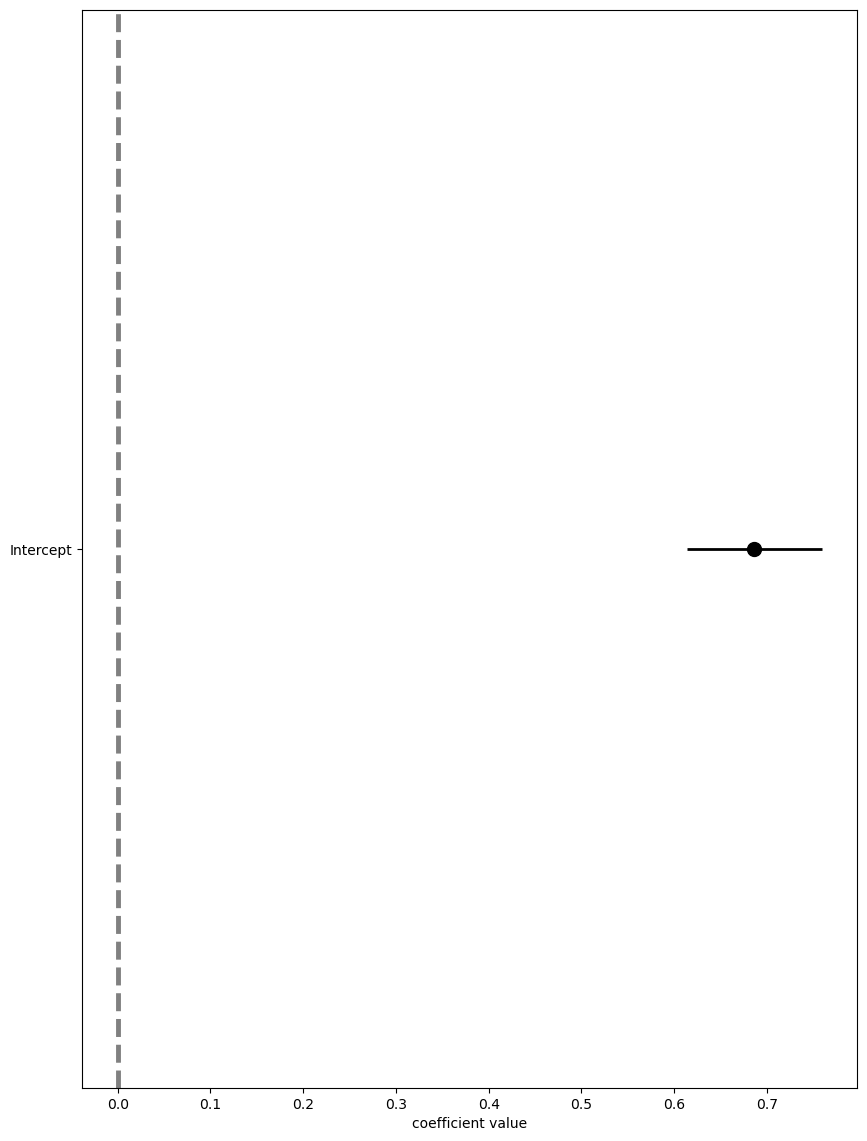

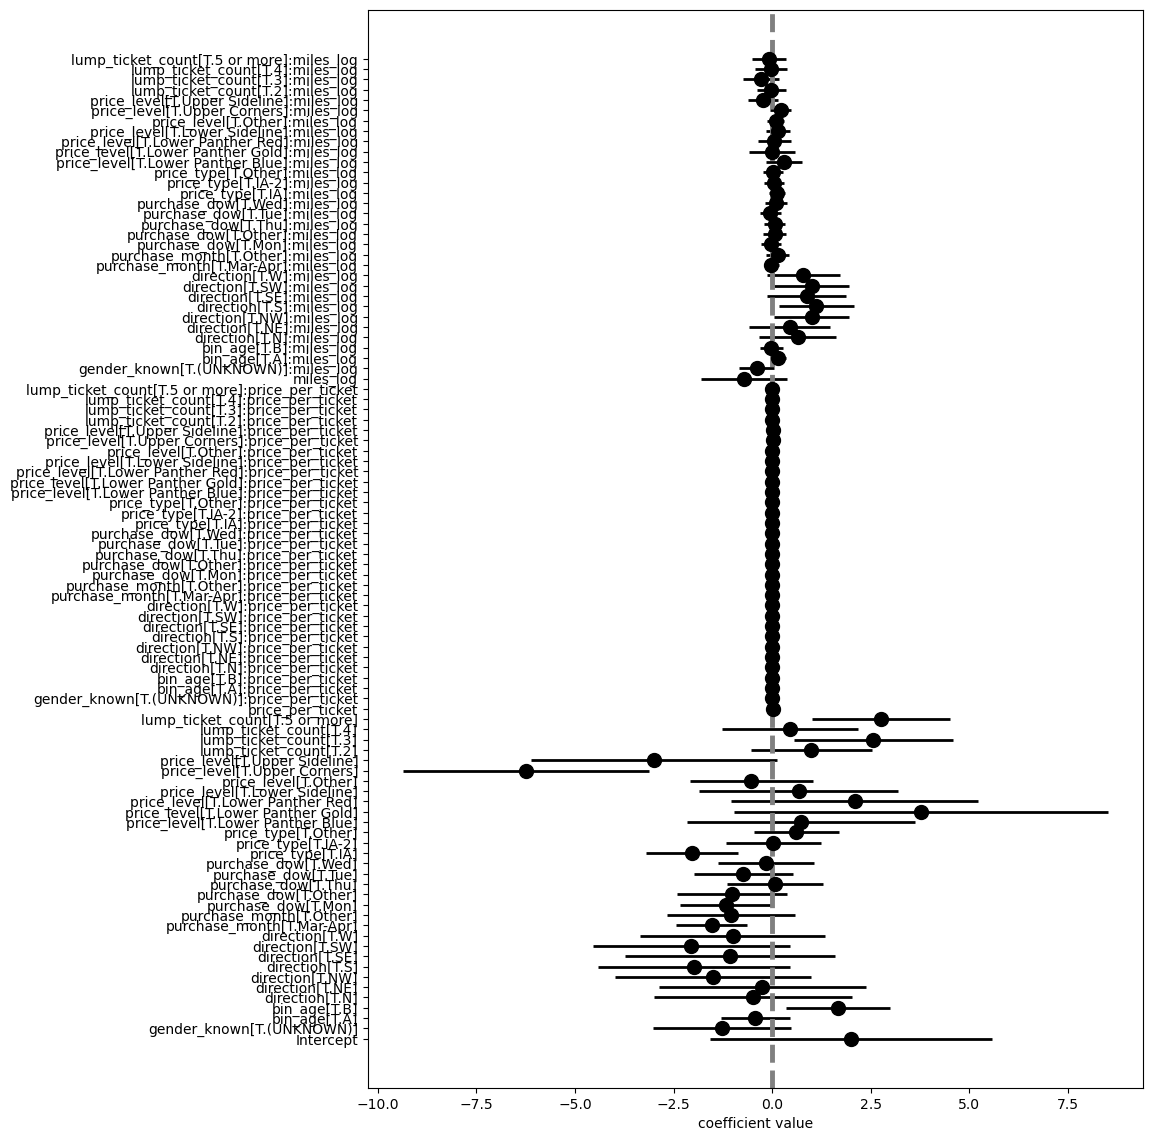

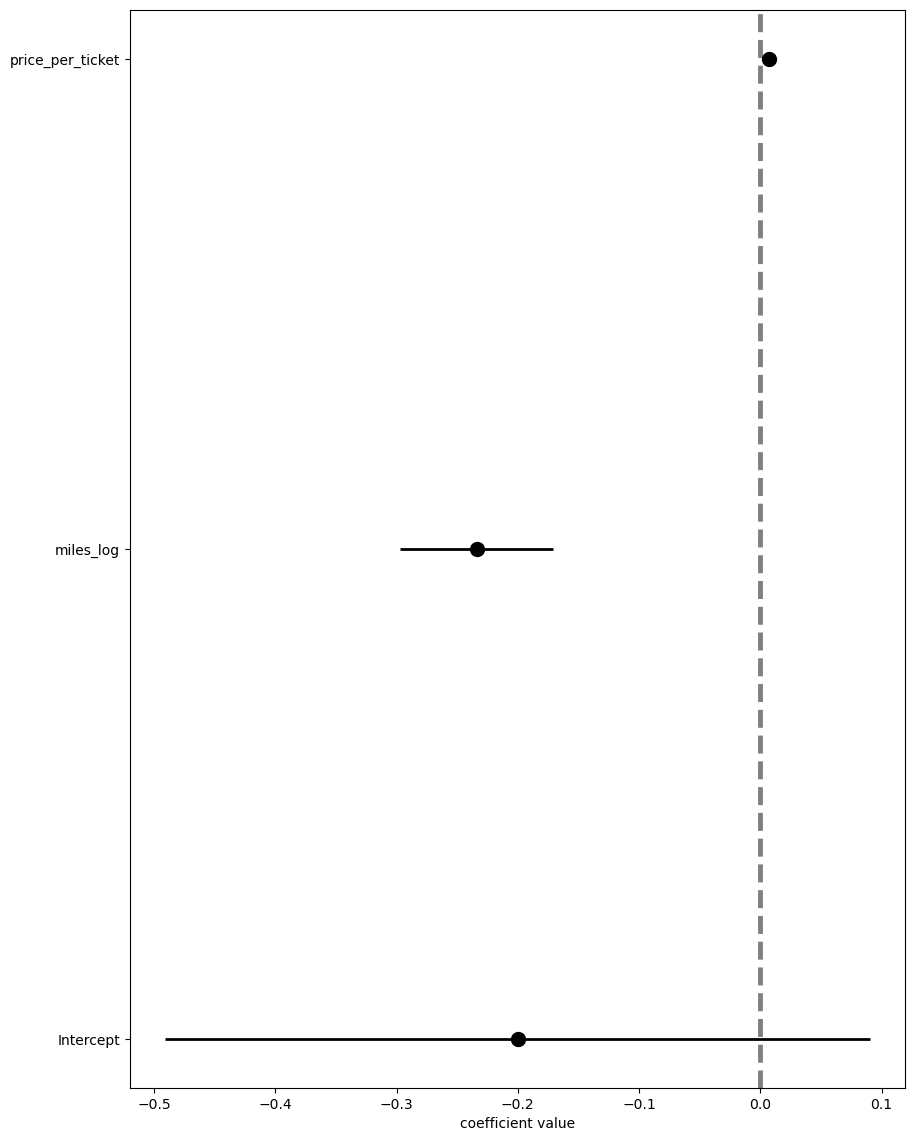

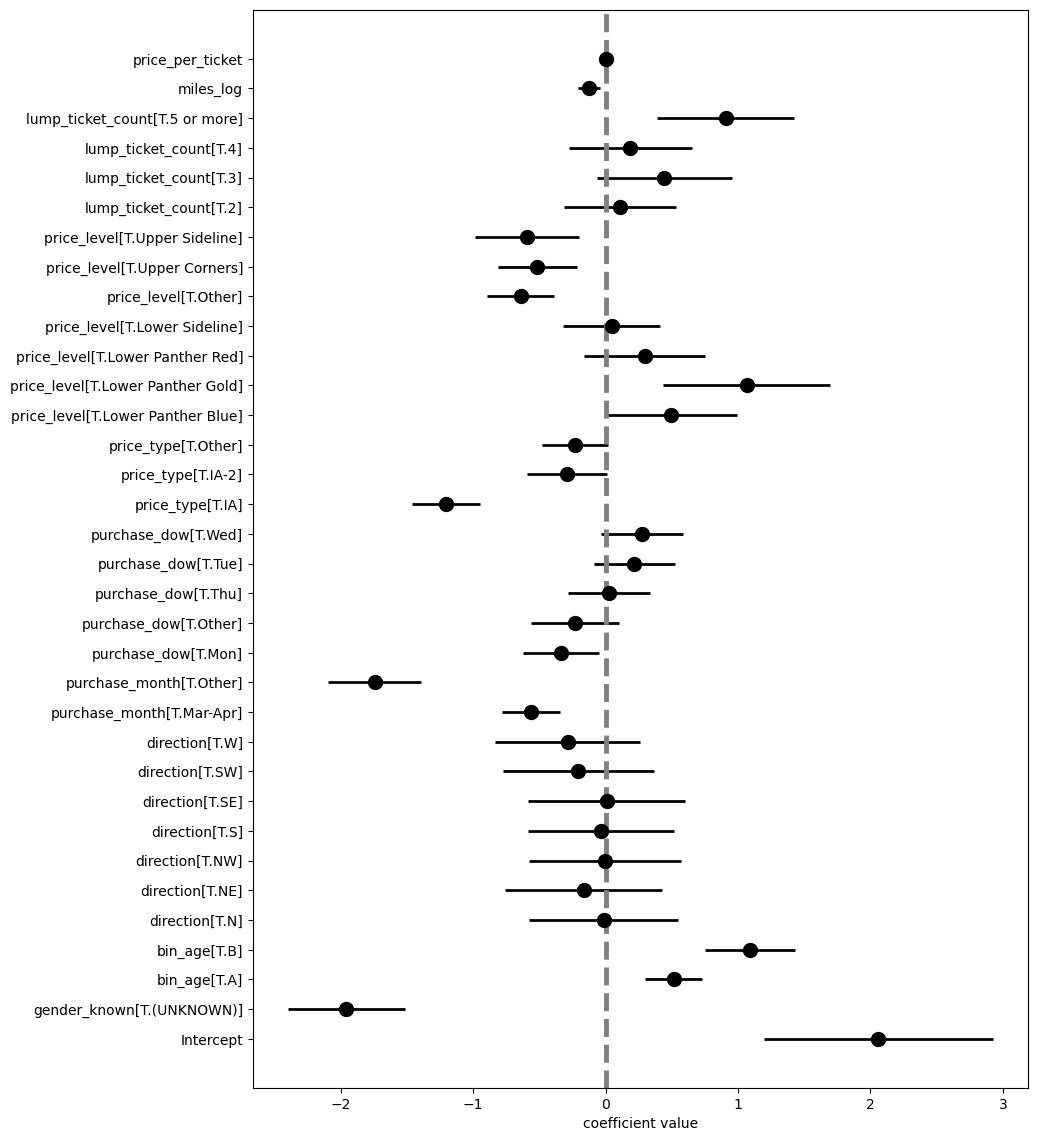

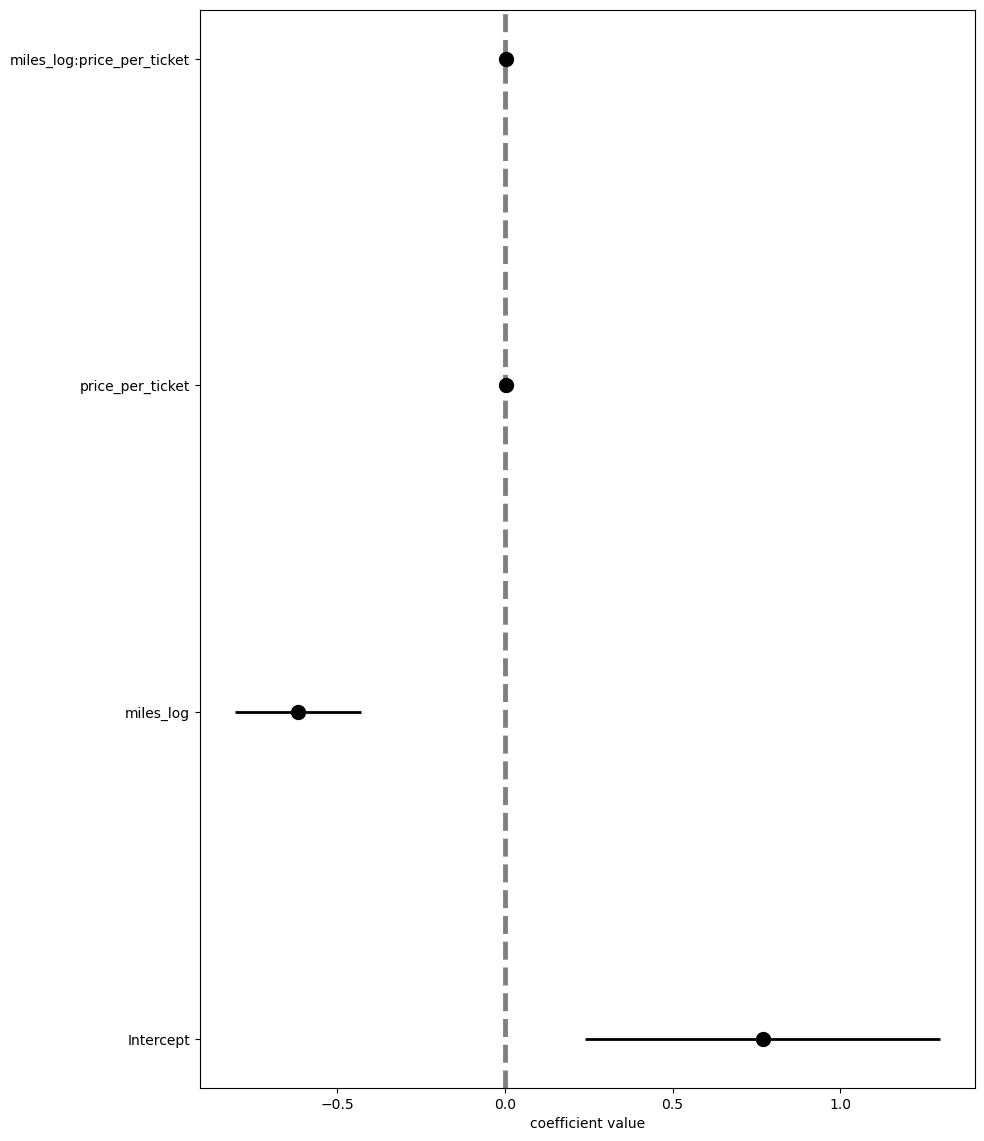

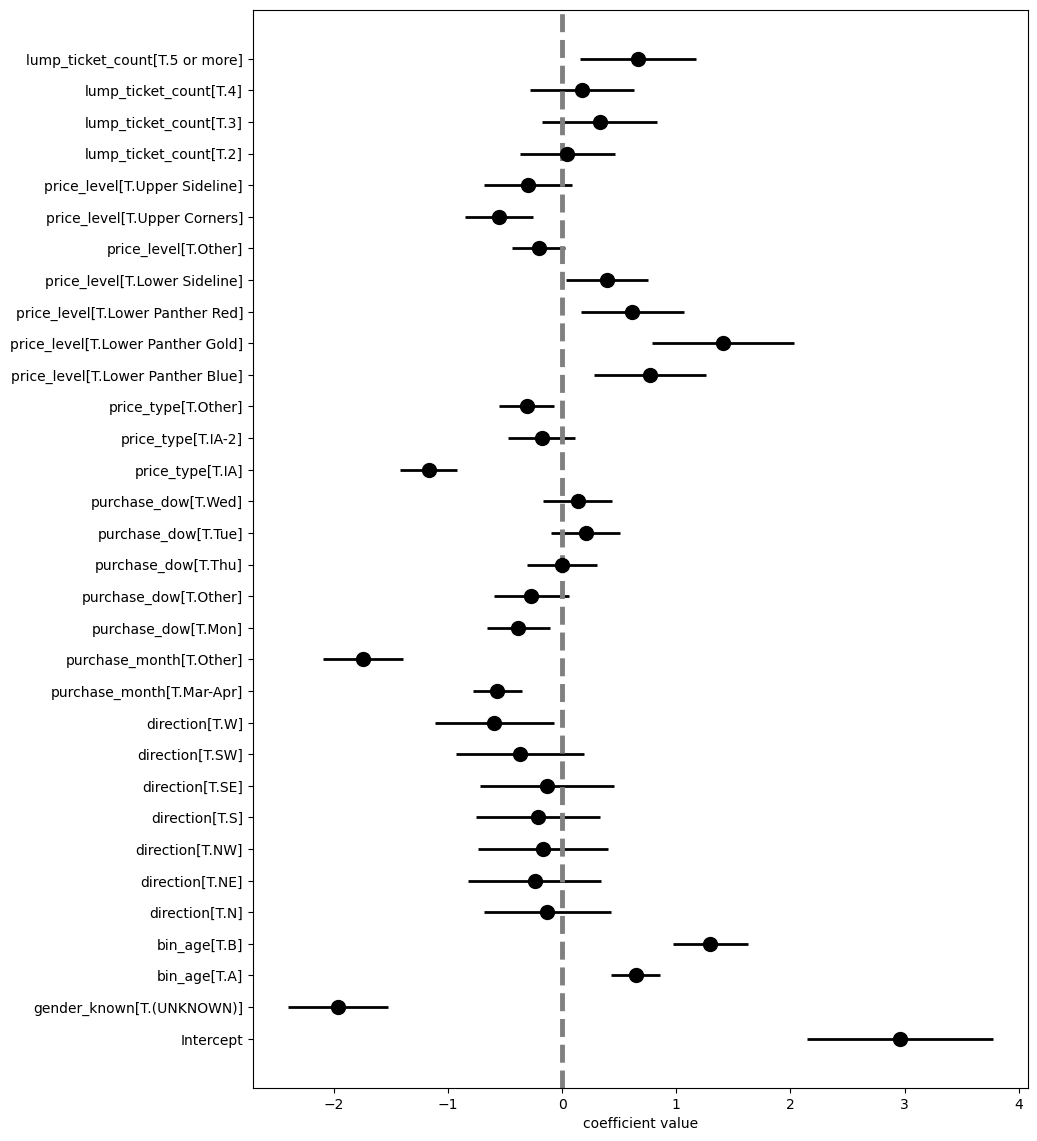

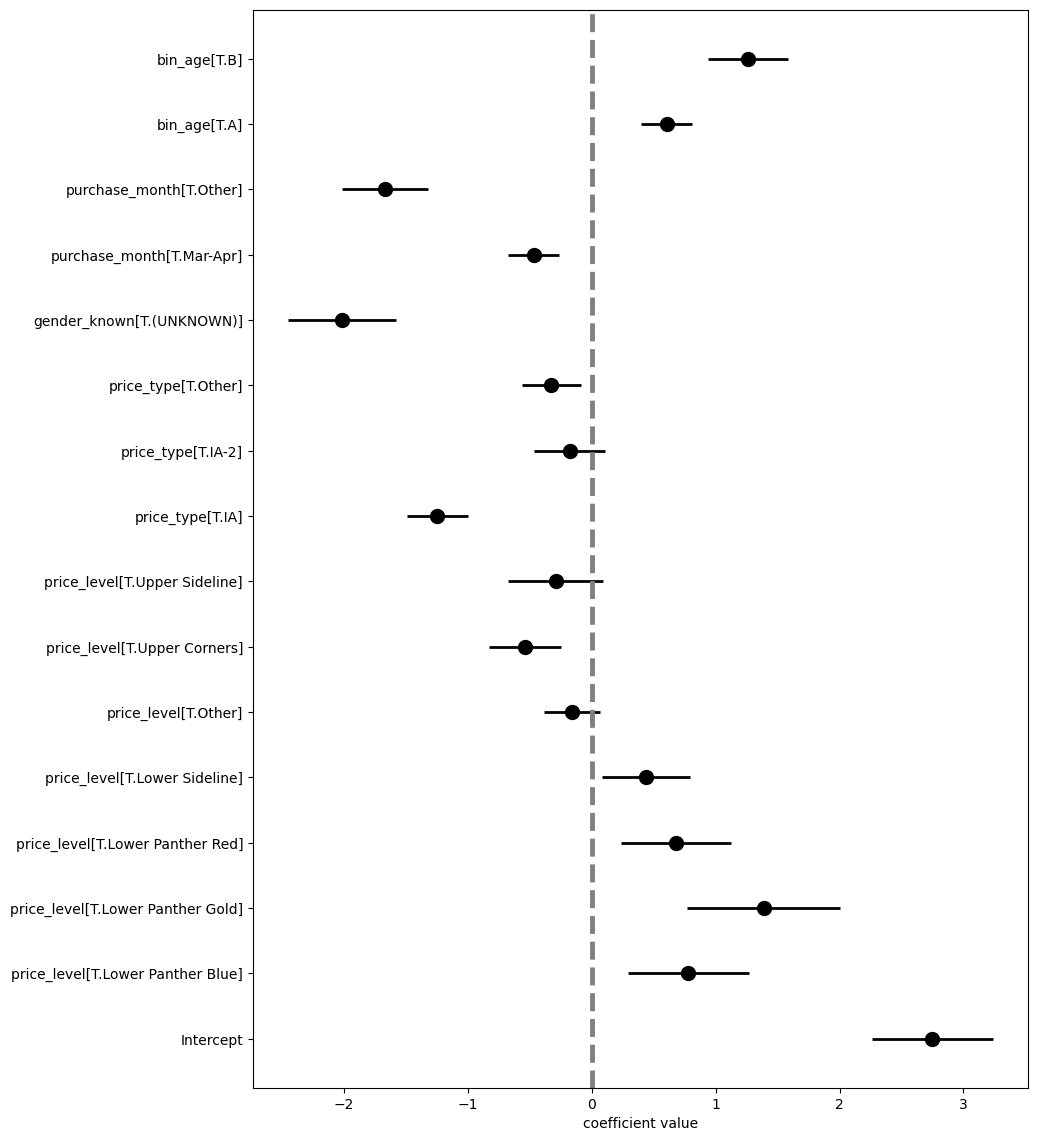

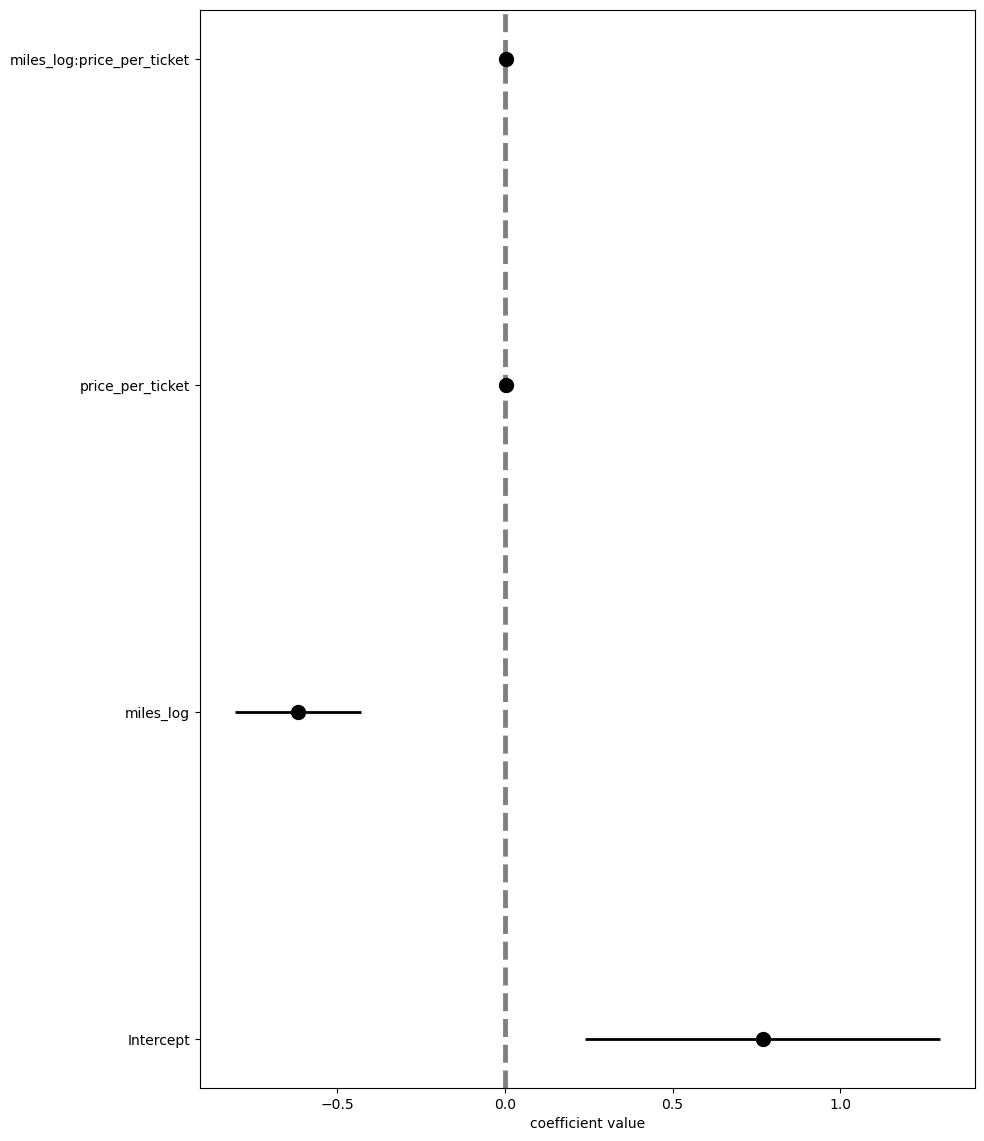

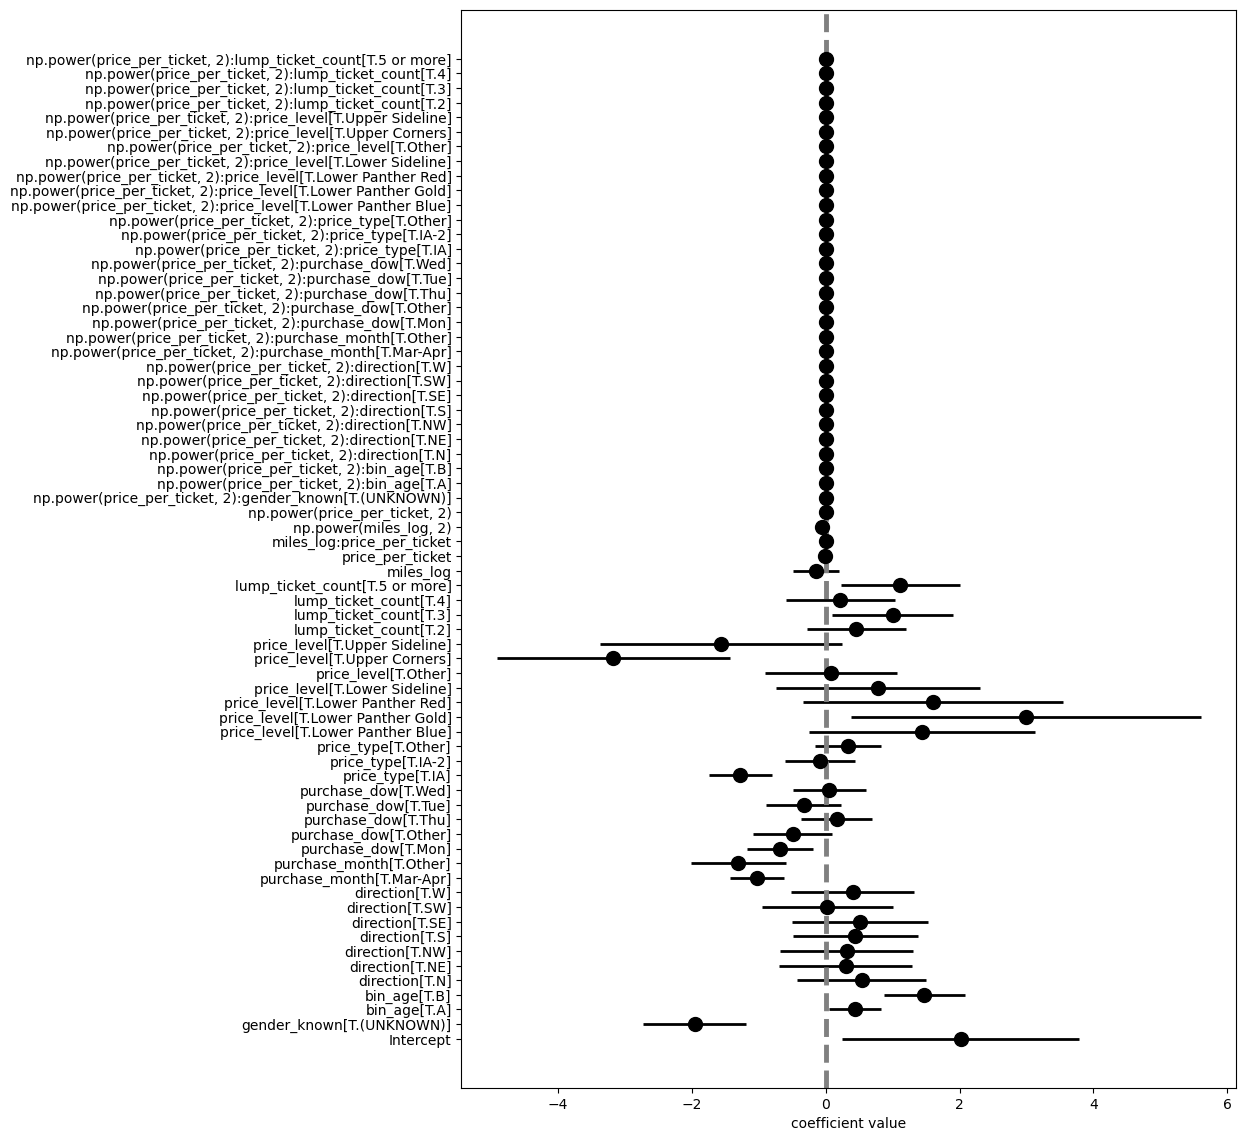

In [58]:
for m in models:
    my_coefplot(m)

## Confusion Matrices
D.h.ii.1

In [59]:
df_model_copy = df_model.copy()

In [60]:
df_model_copy['pred_prob_1'] = fit_1.predict(df_model)

In [61]:
df_model_copy['pred_prob_8'] = fit_8.predict(df_model)

In [62]:
df_model_copy['pred_prob_0'] = fit_0.predict(df_model)

In [63]:
df_model_copy['pred_prob_2'] = fit_2.predict(df_model)

In [64]:
df_model_copy['pred_prob_3'] = fit_3.predict(df_model)

In [65]:
df_model_copy['pred_prob_4'] = fit_4.predict(df_model)

In [66]:
df_model_copy['pred_prob_5'] = fit_5.predict(df_model)

In [67]:
df_model_copy['pred_prob_6'] = fit_6.predict(df_model)

In [68]:
df_model_copy['pred_prob_7'] = fit_7.predict(df_model)

In [69]:
df_model_copy.head()

,accountid,gender_known,bin_age,direction,miles_log,purchase_month,purchase_dow,price_per_ticket,price_type,price_level,...,y,pred_prob_1,pred_prob_8,pred_prob_0,pred_prob_2,pred_prob_3,pred_prob_4,pred_prob_5,pred_prob_6,pred_prob_7
0,1,(UNKNOWN),(UNKNOWN),N,2.381095,Jan-Feb,Mon,252.0,A,Lower Panther Red,...,1,0.833374,0.817445,0.665179,0.738858,0.837747,0.734181,0.806422,0.803947,0.734181
1,2,(UNKNOWN),(UNKNOWN),NE,2.096815,Jan-Feb,Wed,387.0,A,Other,...,1,0.775726,0.824997,0.665179,0.887898,0.838413,0.869637,0.674776,0.638948,0.869637
2,3,(KNOWN),B,S,3.674115,Mar-Apr,Other,252.0,A,Lower Panther Blue,...,1,0.993262,0.983886,0.665179,0.676447,0.980330,0.700956,0.982422,0.986939,0.700956
3,4,(UNKNOWN),A,W,2.927391,Jan-Feb,Other,252.0,A,Lower Panther Red,...,1,0.879657,0.900537,0.665179,0.713453,0.915386,0.720434,0.886418,0.882547,0.720434
4,5,(UNKNOWN),(UNKNOWN),W,2.802609,Jan-Feb,Wed,252.0,A,Lower Panther Blue,...,0,0.825033,0.841004,0.665179,0.719385,0.856581,0.723612,0.794014,0.819406,0.723612


In [70]:
#Classify the training set
df_model_copy['pred_class_1'] = np.where( df_model_copy.pred_prob_1 > 0.5, 1, 0 )


In [71]:
#Classify the training set
df_model_copy['pred_class_8'] = np.where( df_model_copy.pred_prob_8 > 0.5, 1, 0 )


In [72]:
#Classify the training set
df_model_copy['pred_class_0'] = np.where( df_model_copy.pred_prob_0 > 0.5, 1, 0 )


In [73]:
#Classify the training set
df_model_copy['pred_class_3'] = np.where( df_model_copy.pred_prob_2 > 0.5, 1, 0 )


In [74]:
#Classify the training set
df_model_copy['pred_class_4'] = np.where( df_model_copy.pred_prob_4 > 0.5, 1, 0 )


In [75]:
#Classify the training set
df_model_copy['pred_class_5'] = np.where( df_model_copy.pred_prob_5 > 0.5, 1, 0 )


In [76]:
#Classify the training set
df_model_copy['pred_class_6'] = np.where( df_model_copy.pred_prob_6 > 0.5, 1, 0 )


In [77]:
#Classify the training set
df_model_copy['pred_class_7'] = np.where( df_model_copy.pred_prob_7 > 0.5, 1, 0 )


In [78]:
#Classify the training set
df_model_copy['pred_class_2'] = np.where( df_model_copy.pred_prob_2 > 0.5, 1, 0 )


In [79]:
df_model_copy.head()

,accountid,gender_known,bin_age,direction,miles_log,purchase_month,purchase_dow,price_per_ticket,price_type,price_level,...,pred_prob_7,pred_class_1,pred_class_8,pred_class_0,pred_class_3,pred_class_4,pred_class_5,pred_class_6,pred_class_7,pred_class_2
0,1,(UNKNOWN),(UNKNOWN),N,2.381095,Jan-Feb,Mon,252.0,A,Lower Panther Red,...,0.734181,1,1,1,1,1,1,1,1,1
1,2,(UNKNOWN),(UNKNOWN),NE,2.096815,Jan-Feb,Wed,387.0,A,Other,...,0.869637,1,1,1,1,1,1,1,1,1
2,3,(KNOWN),B,S,3.674115,Mar-Apr,Other,252.0,A,Lower Panther Blue,...,0.700956,1,1,1,1,1,1,1,1,1
3,4,(UNKNOWN),A,W,2.927391,Jan-Feb,Other,252.0,A,Lower Panther Red,...,0.720434,1,1,1,1,1,1,1,1,1
4,5,(UNKNOWN),(UNKNOWN),W,2.802609,Jan-Feb,Wed,252.0,A,Lower Panther Blue,...,0.723612,1,1,1,1,1,1,1,1,1


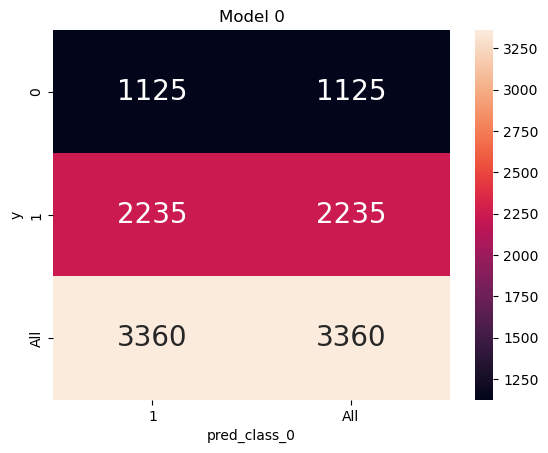

In [80]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_0, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 0')

plt.show()


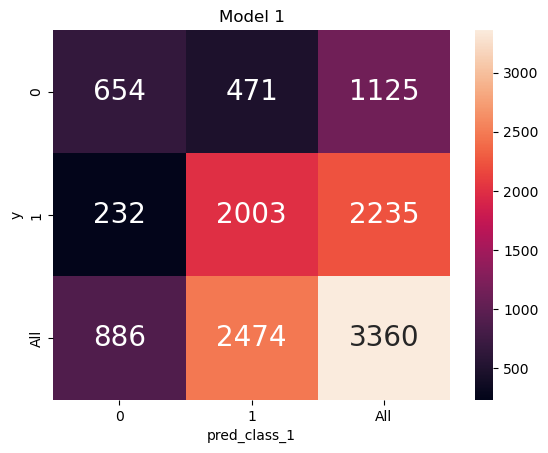

In [81]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_1, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 1')

plt.show()


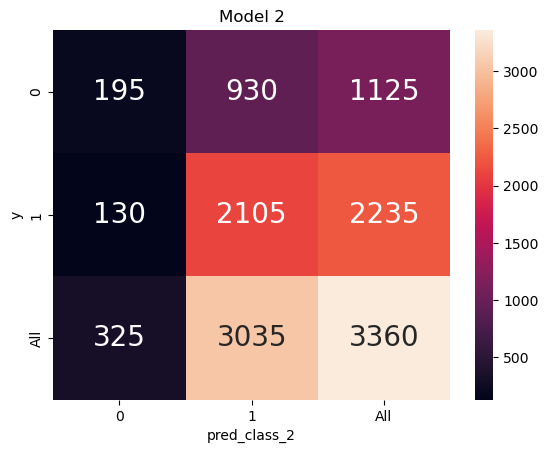

In [82]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_2, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 2')

plt.show()


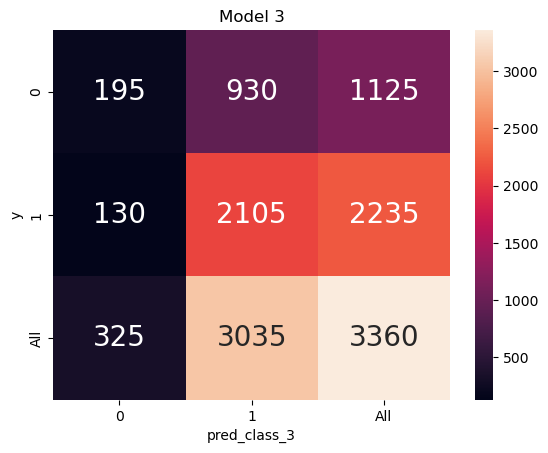

In [83]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_3, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 3')

plt.show()


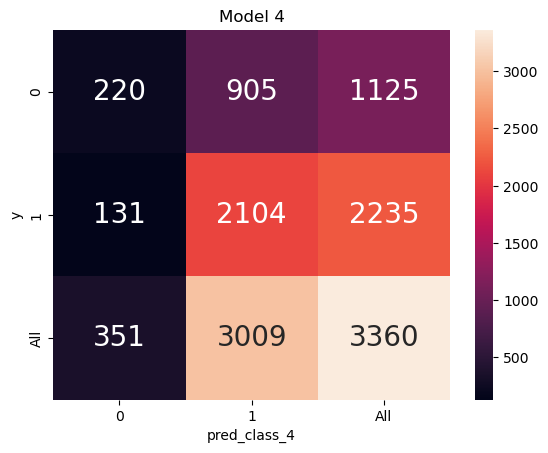

In [84]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_4, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 4')

plt.show()


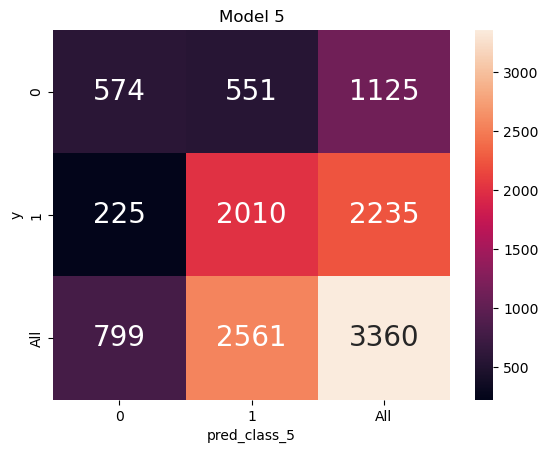

In [85]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_5, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 5')

plt.show()


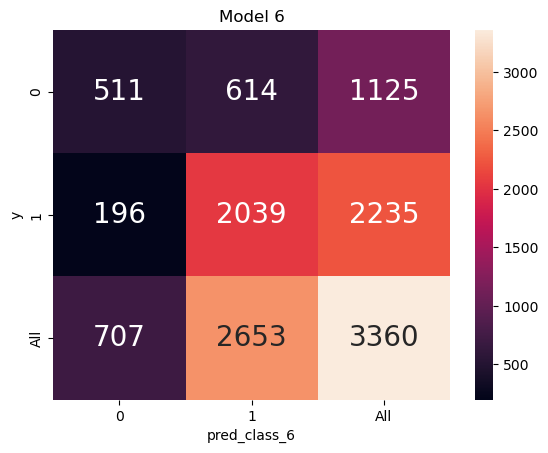

In [86]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_6, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 6')

plt.show()


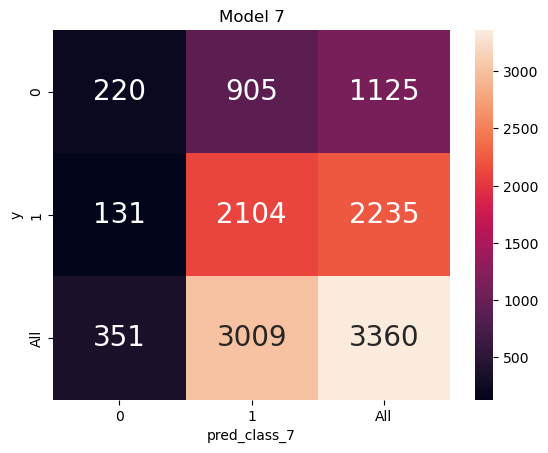

In [87]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_7, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 7')

plt.show()


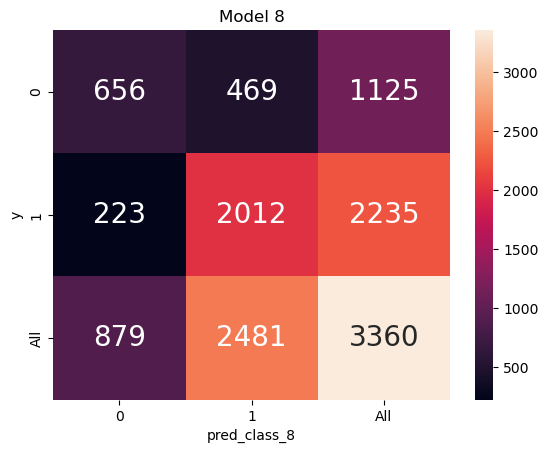

In [88]:
fig, ax = plt.subplots()

sns.heatmap( pd.crosstab(df_model_copy.y, df_model_copy.pred_class_8, margins=True),
             annot=True, annot_kws={'size': 20}, fmt='3d' )

ax.set_title('Model 8')

plt.show()


In [89]:
#D.h.ii.2

#The model with the best performance on the training set is model 8
# The model changes to model 1 when based on ROC_AUC
# The best model is far better than the INTERCEPT-ONLY model
# The best model (8) has 68 coefficinets; (1) has 96

In [90]:
def fit_logistic_make_roc(mod_name, a_formula, train_data):
    a_mod = smf.logit(formula=a_formula, data=train_data).fit()
    
    train_copy = train_data.copy()
    
    train_copy['pred_probability'] = a_mod.predict( train_data )
    
    fpr, tpr, threshold = roc_curve( train_data.y.to_numpy(), train_copy.pred_probability.to_numpy() )
    
    res_df = pd.DataFrame({'tpr': tpr,
                           'fpr': fpr,
                           'threshold': threshold})
    
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    
    return res_df

In [91]:
roc_list = []

for m in range( len(formula_list) ):
    roc_list.append( fit_logistic_make_roc( m, formula_list[m], train_data=df_model))


Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.446748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.598729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.487048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450918
         Iterations 8


In [92]:
roc_df = pd.concat( roc_list, ignore_index=True )

In [93]:
roc_df['model_name'] = roc_df.model_name.astype('category')

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


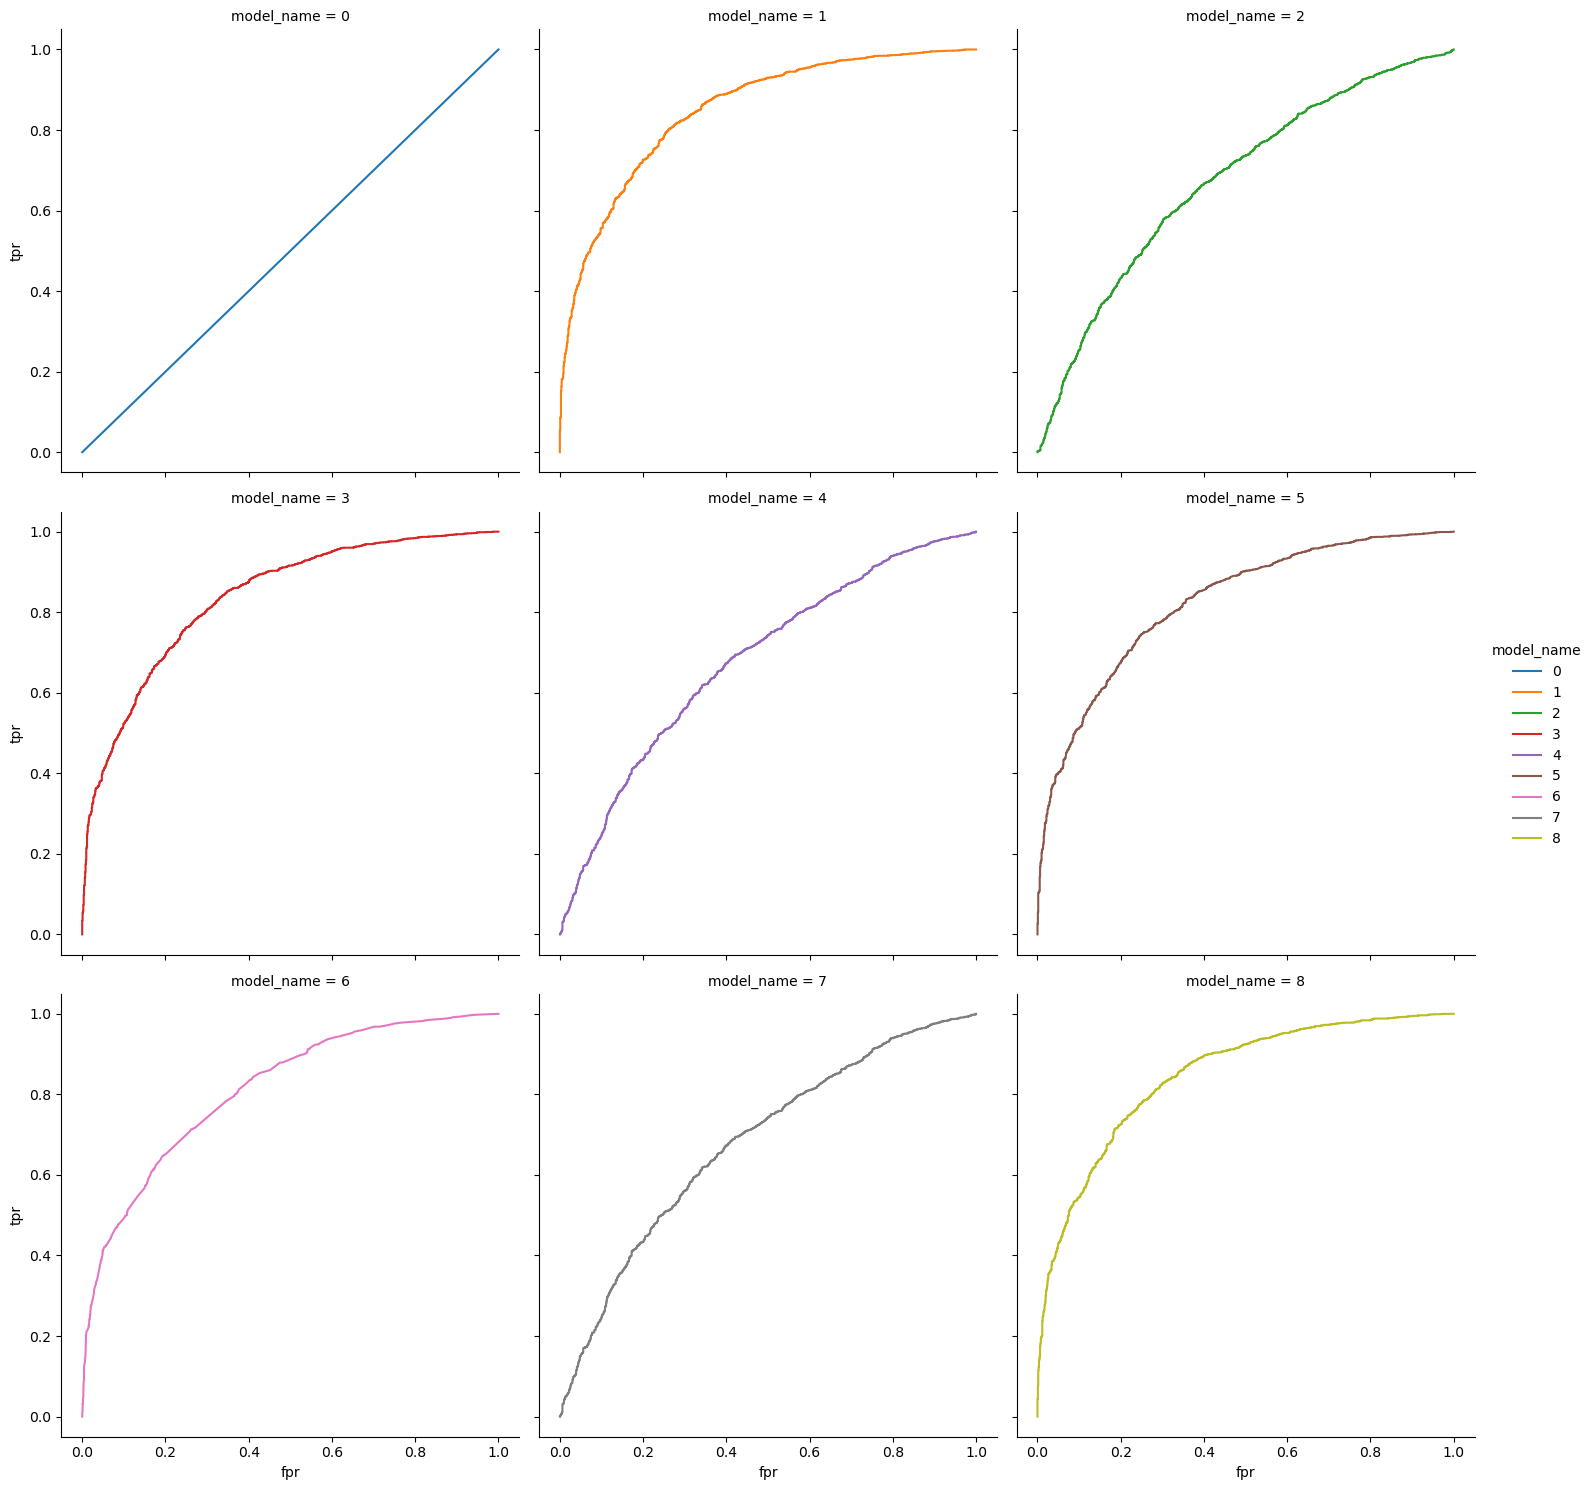

In [94]:
sns.relplot(data = roc_df, x='fpr', y='tpr', hue='model_name',
            kind='line', estimator=None, units='model_name',
            col='model_name', col_wrap=3)

plt.show()

## E. Predictions

In [95]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accountid          3360 non-null   int64  
 1   gender_known       3360 non-null   object 
 2   bin_age            3360 non-null   object 
 3   direction          3360 non-null   object 
 4   miles_log          3360 non-null   float64
 5   purchase_month     3360 non-null   object 
 6   purchase_dow       3360 non-null   object 
 7   price_per_ticket   3360 non-null   float64
 8   price_type         3360 non-null   object 
 9   price_level        3360 non-null   object 
 10  lump_ticket_count  3360 non-null   object 
 11  y                  3360 non-null   int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 315.1+ KB


In [96]:
input_grid_1 = pd.DataFrame([ (gender_known, 
                             bin_age, 
                             direction, 
                             miles_log, 
                             purchase_month,
                             purchase_dow,
                             price_per_ticket,
                             price_type,
                             price_level,
                             lump_ticket_count) 
                             for gender_known in df_model.gender_known.mode()
                             for bin_age in df_model.bin_age.mode()
                             for direction in df_model.direction.unique()
                             for miles_log in [df_model.miles_log.mean()]
                             for purchase_month in df_model.purchase_month.mode()
                             for purchase_dow in df_model.purchase_dow.mode()
                             for price_per_ticket in np.linspace(df_model.price_per_ticket.min(), df_model.price_per_ticket.max(), num=101)
                             for price_type in df_model.price_type.mode()
                             for price_level in df_model.price_level.unique()
                             for lump_ticket_count in df_model.lump_ticket_count.mode() ],
                          columns=['gender_known','bin_age', 'direction', 'miles_log', 'purchase_month', 'purchase_dow', 'price_per_ticket',
                                  'price_type', 'price_level', 'lump_ticket_count'])

In [97]:
input_grid_1

,gender_known,bin_age,direction,miles_log,purchase_month,purchase_dow,price_per_ticket,price_type,price_level,lump_ticket_count
0,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Lower Panther Red,2
1,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Other,2
2,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Lower Panther Blue,2
3,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Lower End Zone,2
4,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Upper Corners,2
...,...,...,...,...,...,...,...,...,...,...
6459,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Lower End Zone,2
6460,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Upper Corners,2
6461,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Lower Sideline,2
6462,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Lower Panther Gold,2


In [98]:
input_grid_1.shape


(6464, 10)

In [99]:
df_viz_1 = input_grid_1.copy()

In [100]:
df_viz_1['pred_prob_1'] = fit_1.predict(input_grid_1)

In [101]:
df_viz_1

,gender_known,bin_age,direction,miles_log,purchase_month,purchase_dow,price_per_ticket,price_type,price_level,lump_ticket_count,pred_prob_1
0,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Lower Panther Red,2,0.727074
1,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Other,2,0.176554
2,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Lower Panther Blue,2,0.576068
3,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Lower End Zone,2,0.219641
4,(UNKNOWN),(UNKNOWN),N,2.723226,Jan-Feb,Mon,0.0,A,Upper Corners,2,0.000980
...,...,...,...,...,...,...,...,...,...,...,...
6459,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Lower End Zone,2,0.942798
6460,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Upper Corners,2,0.999881
6461,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Lower Sideline,2,0.849541
6462,(UNKNOWN),(UNKNOWN),NW,2.723226,Jan-Feb,Mon,387.0,A,Lower Panther Gold,2,0.823811


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


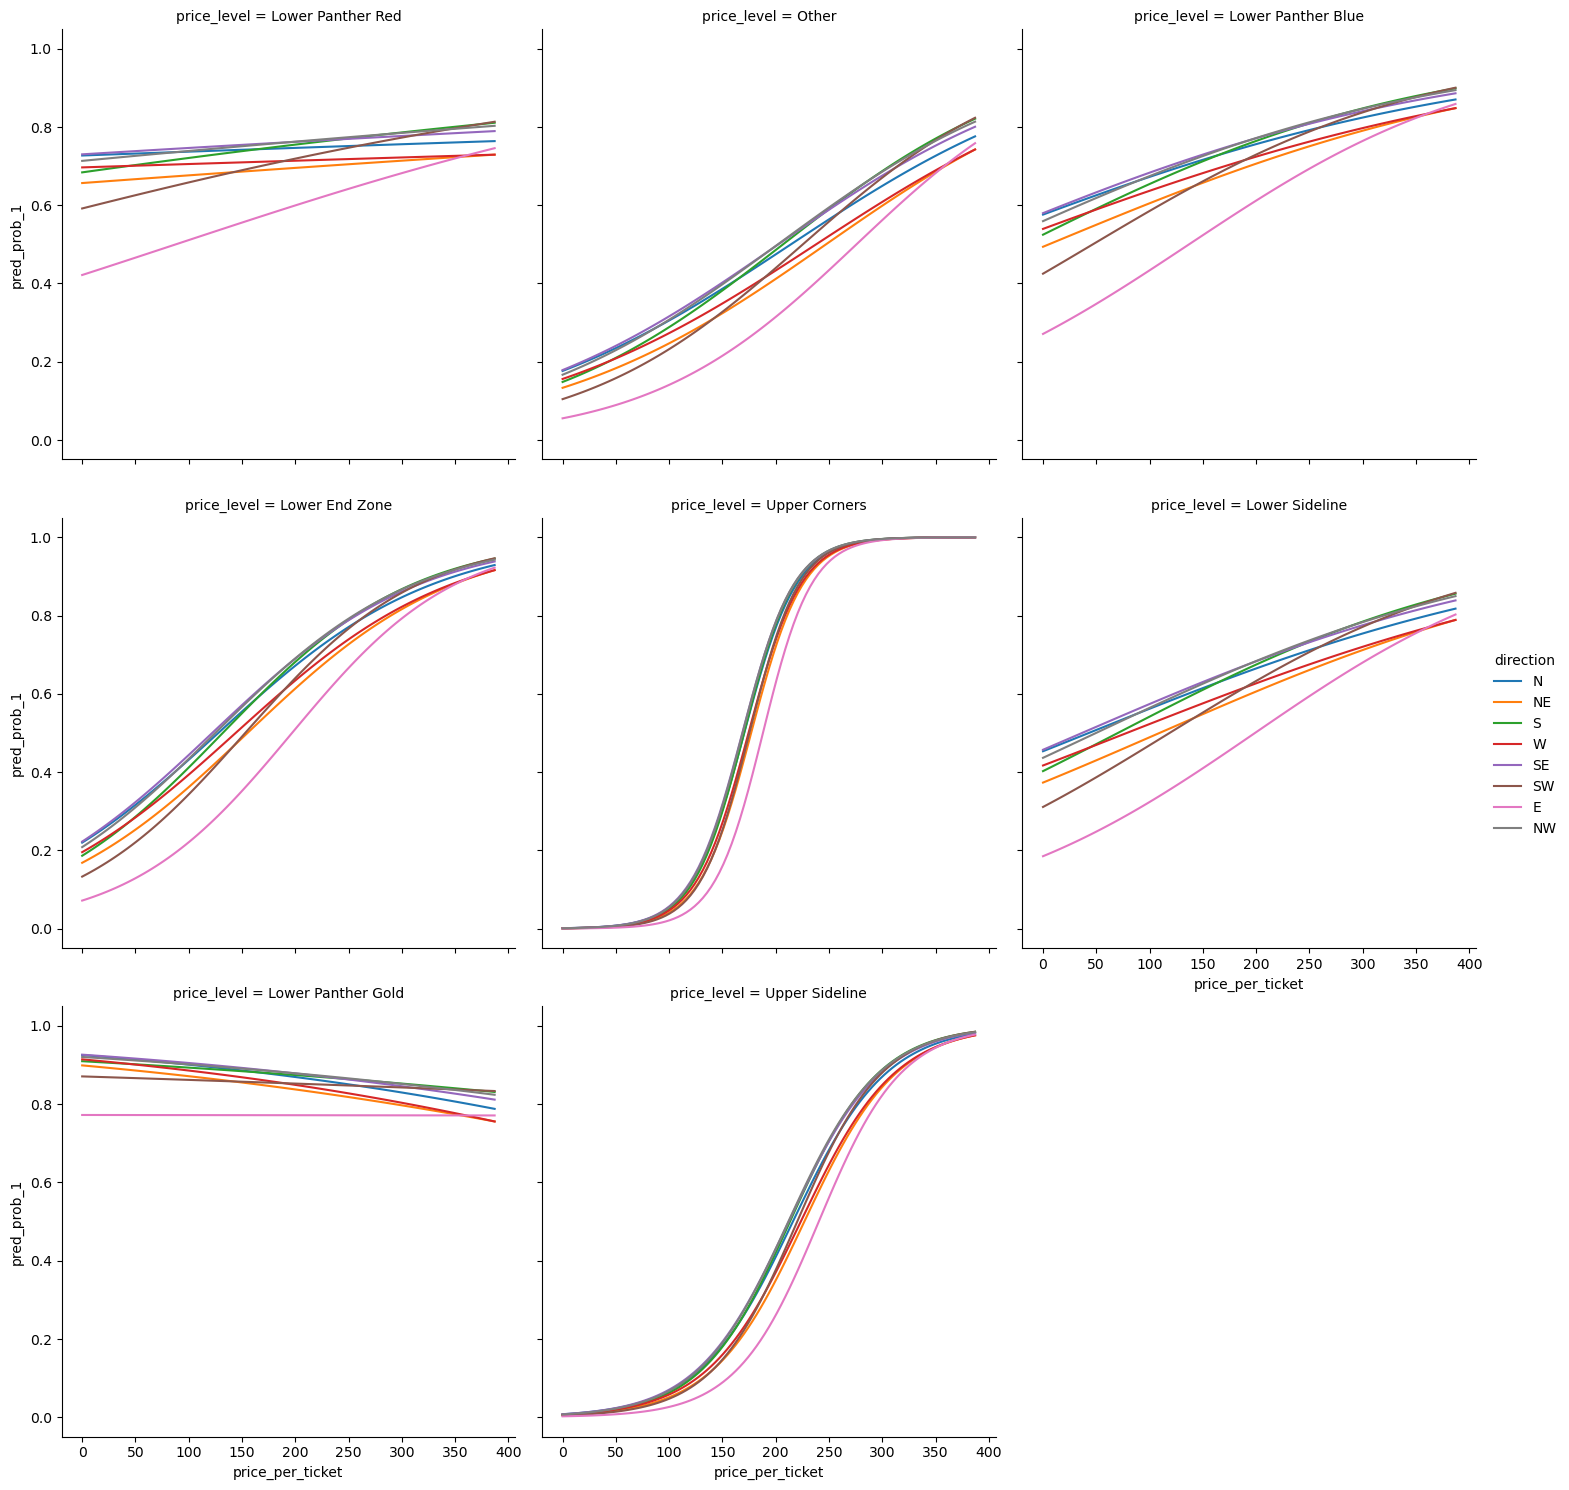

In [102]:
sns.relplot(data = df_viz_1, x='price_per_ticket', y='pred_prob_1', hue='direction', col='price_level',
            kind='line', estimator=None, units='direction', col_wrap=3)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


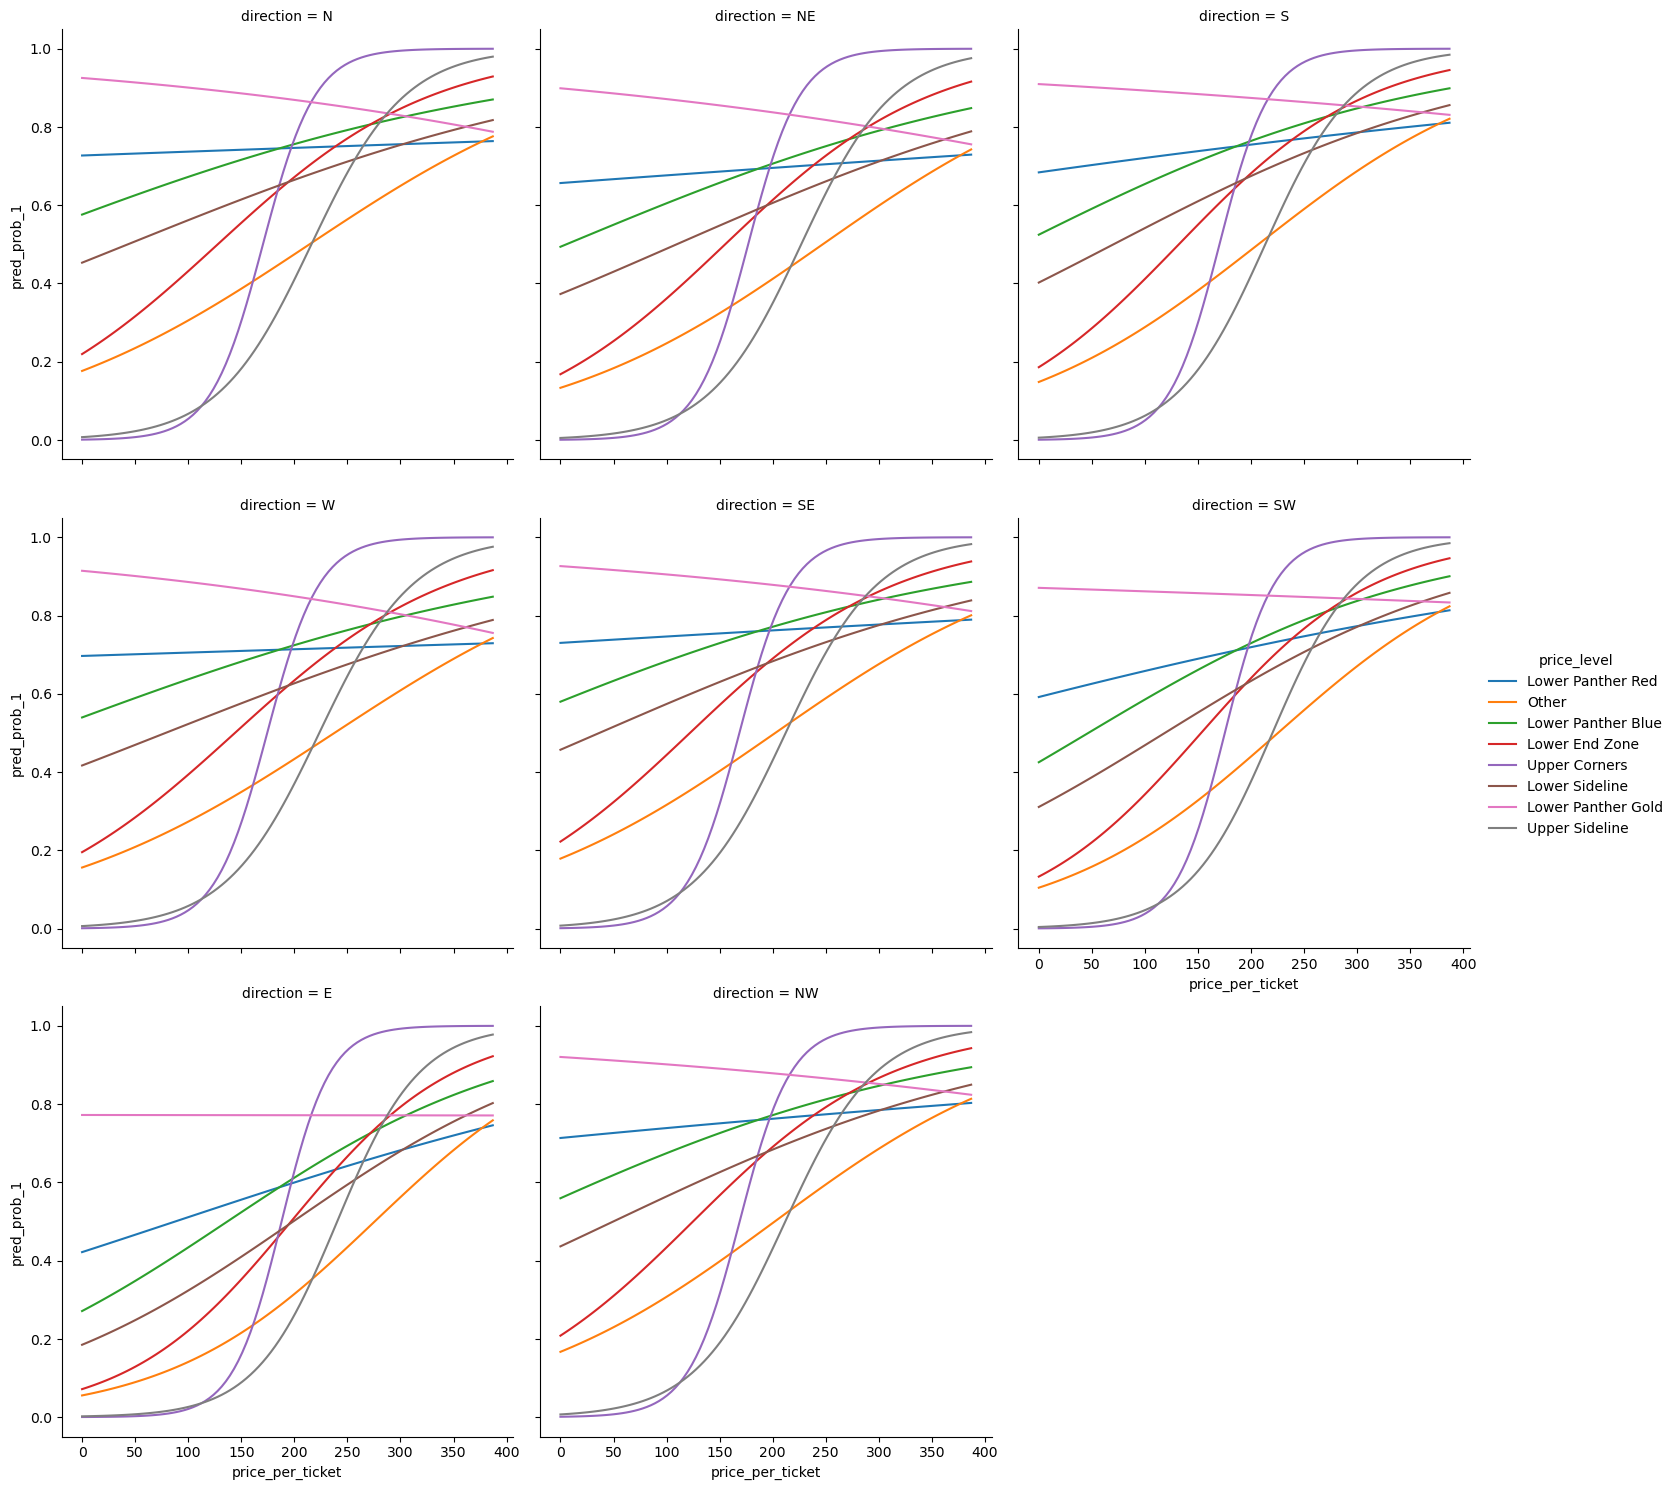

In [103]:
sns.relplot(data = df_viz_1, x='price_per_ticket', y='pred_prob_1', hue='price_level', col='direction',
            kind='line', estimator=None, units='price_level', col_wrap=3)

plt.show()

An observation is that no matter the direction, the more expensive the ticket, the less likely someone in Lower Panther Gold is to renew their tickets

In [104]:
input_grid_3 = pd.DataFrame([ (gender_known, 
                             bin_age, 
                             direction, 
                             miles_log, 
                             purchase_month,
                             purchase_dow,
                             price_per_ticket,
                             price_type,
                             price_level,
                             lump_ticket_count) 
                             for gender_known in df_model.gender_known.unique()
                             for bin_age in df_model.bin_age.mode()
                             for direction in df_model.direction.mode()
                             for miles_log in np.linspace(df_model.miles_log.min(), df_model.miles_log.max(), num = 101)
                             for purchase_month in df_model.purchase_month.mode()
                             for purchase_dow in df_model.purchase_dow.mode()
                             for price_per_ticket in [df_model.price_per_ticket.mean()]
                             for price_type in df_model.price_type.mode()
                             for price_level in df_model.price_level.unique()
                             for lump_ticket_count in df_model.lump_ticket_count.mode() ],
                          columns=['gender_known','bin_age', 'direction', 'miles_log', 'purchase_month', 'purchase_dow', 'price_per_ticket',
                                  'price_type', 'price_level', 'lump_ticket_count'])

In [105]:
input_grid_3

,gender_known,bin_age,direction,miles_log,purchase_month,purchase_dow,price_per_ticket,price_type,price_level,lump_ticket_count
0,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Lower Panther Red,2
1,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Other,2
2,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Lower Panther Blue,2
3,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Lower End Zone,2
4,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Upper Corners,2
...,...,...,...,...,...,...,...,...,...,...
1611,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Lower End Zone,2
1612,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Upper Corners,2
1613,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Lower Sideline,2
1614,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Lower Panther Gold,2


In [106]:
df_viz_3 = input_grid_3.copy()

In [107]:
df_viz_3['pred_prob_3'] = fit_3.predict(input_grid_3)

In [108]:
df_viz_3

,gender_known,bin_age,direction,miles_log,purchase_month,purchase_dow,price_per_ticket,price_type,price_level,lump_ticket_count,pred_prob_3
0,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Lower Panther Red,2,0.802795
1,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Other,2,0.615535
2,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Lower Panther Blue,2,0.832417
3,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Lower End Zone,2,0.752131
4,(UNKNOWN),(UNKNOWN),W,-1.856544,Jan-Feb,Mon,223.462917,A,Upper Corners,2,0.644517
...,...,...,...,...,...,...,...,...,...,...,...
1611,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Lower End Zone,2,0.892655
1612,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Upper Corners,2,0.832461
1613,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Lower Sideline,2,0.896946
1614,(KNOWN),(UNKNOWN),W,5.610524,Jan-Feb,Mon,223.462917,A,Lower Panther Gold,2,0.960257


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


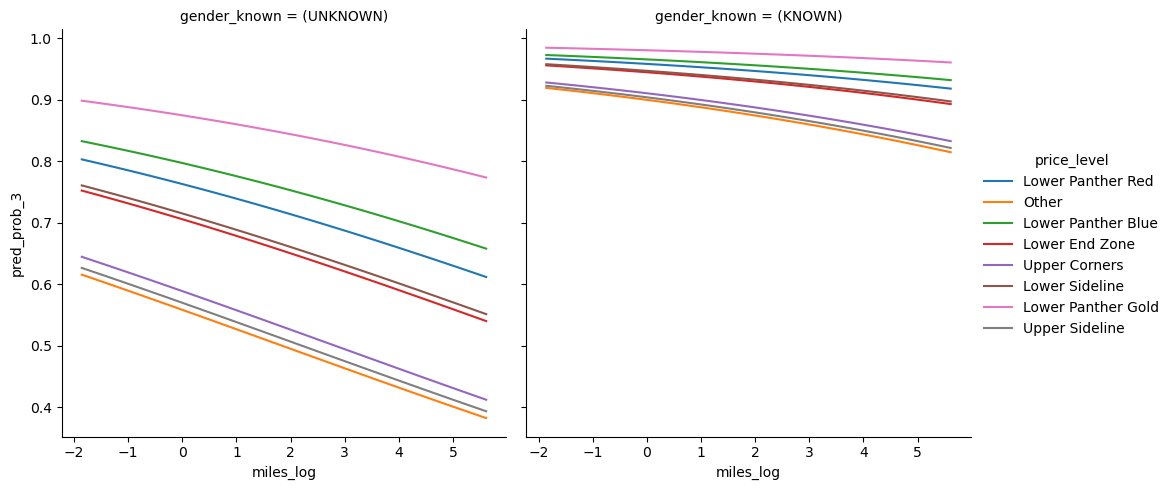

In [109]:
sns.relplot(data = df_viz_3, x='miles_log', y='pred_prob_3', hue='price_level', col='gender_known',
            kind='line', estimator=None, units='price_level')

plt.show()

## F: Performance and Validation

In [110]:
from sklearn.model_selection import StratifiedKFold

In [111]:
kf = StratifiedKFold( n_splits=5, shuffle=True, random_state=9483156 )

In [112]:
input_names = df_model.drop(columns=['y']).copy().columns.to_list()
output_name = 'y'

In [113]:
def train_and_test_logistic_with_cv(mod_name, a_formula, data_df, x_names, y_name, cv, threshold=0.5):
    # separate the inputs and output
    input_df = data_df.loc[ :, x_names ].copy()
    
    # initialize the performance metric storage lists
    train_res = []
    test_res = []
    
    # SPLIT the data and iterate over the folds
    for train_id, test_id in cv.split( input_df.to_numpy(), data_df[ y_name ].to_numpy() ):
        # subset the training and test splits within each fold
        train_data = data_df.iloc[ train_id, :].copy()
        test_data = data_df.iloc[ test_id, :].copy()
        
        # FIT the model on the TRAINING data within the current FOLD
        a_mod = smf.logit(formula=a_formula, data=train_data).fit()
        
        # PREDICT the TRAINING within each FOLD
        train_copy = train_data.copy()
        train_copy['pred_probability'] = a_mod.predict( train_data )
        train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0 )
        
        # PREDICT the TESTING within each FOLD
        test_copy = test_data.copy()
        test_copy['pred_probability'] = a_mod.predict( test_data )
        test_copy['pred_class'] = np.where( test_copy.pred_probability > threshold, 1, 0)
        
        # calculate the PERFORMANCE METRIC on the TRAINING SET within the FOLD
        train_res.append( np.mean( train_copy[ y_name ] == train_copy.pred_class ) )
        
        # calculate the PERFORMANCE METRIC on the TESTING SET within the FOLD
        test_res.append( np.mean( test_copy[ y_name ] == test_copy.pred_class ) )
    
    #store the results
    train_df = pd.DataFrame({'Accuracy': train_res})
    train_df['from_set'] = 'training'
    train_df['fold_id'] = train_df.index + 1
    
    test_df = pd.DataFrame({'Accuracy': test_res})
    test_df['from_set'] = 'testing'
    test_df['fold_id'] = test_df.index + 1
    
    # combine the splits together
    res_df = pd.concat([train_df, test_df], ignore_index=True)
    
    # add information about the model
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    res_df['num_coefs'] = len( a_mod.params )
    res_df['threshold'] = threshold
    
    return res_df


In [114]:
train_and_test_logistic_with_cv(1, formula_list[1], data_df=df_model, x_names=input_names, y_name=output_name, cv=kf)

Optimization terminated successfully.
         Current function value: 0.447902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.440113
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.451355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.438072
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.439221
         Iterations 8


,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.790923,training,1,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
1,0.796503,training,2,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
2,0.788318,training,3,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
3,0.796875,training,4,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
4,0.795759,training,5,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
5,0.787202,testing,1,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
6,0.775298,testing,2,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
7,0.799107,testing,3,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
8,0.769345,testing,4,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5
9,0.778274,testing,5,1,y ~ (gender_known + bin_age + direction + purc...,96,0.5


In [115]:
results_list = []

for m in range( len(formula_list) ):
    print( '-- Formula ID %d -- ' % m )
    
    results_list.append( train_and_test_logistic_with_cv(m, formula_list[m], data_df=df_model, x_names=input_names, y_name=output_name, cv=kf) )


-- Formula ID 0 -- 
Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637541
         Iterations 4
-- Formula ID 1 -- 
Optimization terminated successfully.
         Current function value: 0.447902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.440113
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.451355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.438072
         Iterations 8
Optimization terminated successfully.
    

In [116]:
cv_results = pd.concat( results_list, ignore_index=True )

In [117]:
cv_results

,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.665179,training,1,0,y ~ 1,1,0.5
1,0.665179,training,2,0,y ~ 1,1,0.5
2,0.665179,training,3,0,y ~ 1,1,0.5
3,0.665179,training,4,0,y ~ 1,1,0.5
4,0.665179,training,5,0,y ~ 1,1,0.5
...,...,...,...,...,...,...,...
85,0.794643,testing,1,8,y ~ (miles_log + price_per_ticket)**2 + np.pow...,68,0.5
86,0.778274,testing,2,8,y ~ (miles_log + price_per_ticket)**2 + np.pow...,68,0.5
87,0.799107,testing,3,8,y ~ (miles_log + price_per_ticket)**2 + np.pow...,68,0.5
88,0.772321,testing,4,8,y ~ (miles_log + price_per_ticket)**2 + np.pow...,68,0.5


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


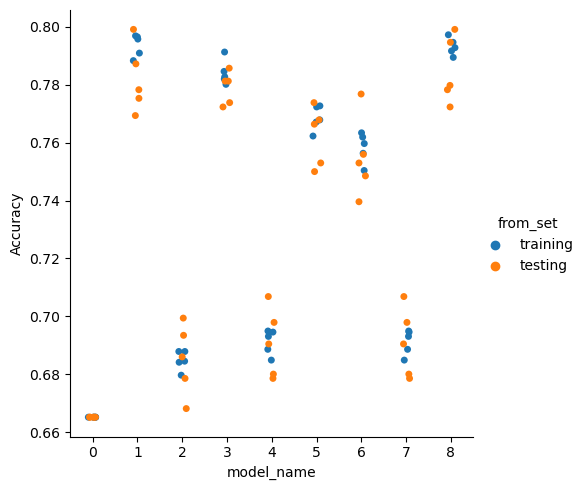

In [118]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set')

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


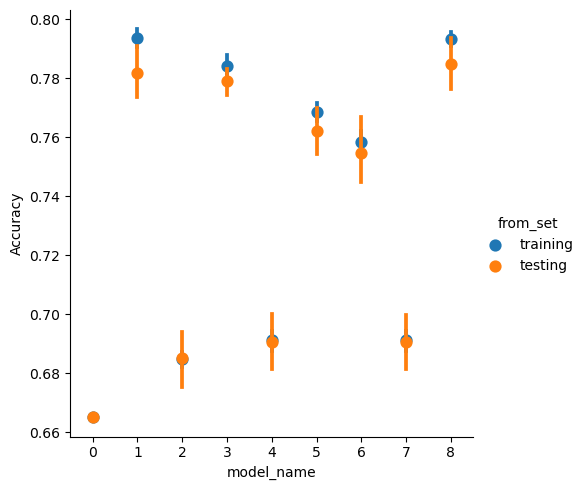

In [119]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False)

plt.show()

#F.c. - visualize by showing hte average cross validation performance metric with the 95% confidence interval

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


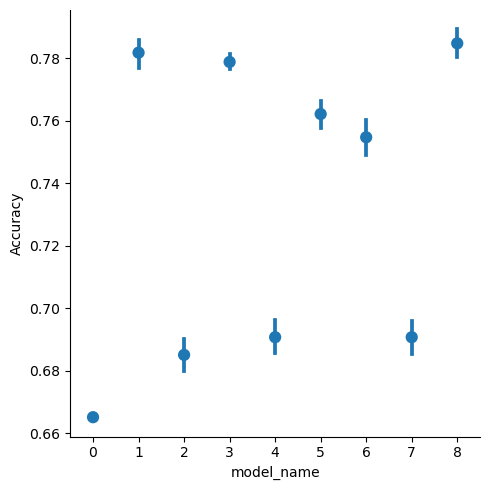

In [120]:
sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
            x='model_name', y='Accuracy', kind='point', join=False,
            errorbar=('ci', 68))

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


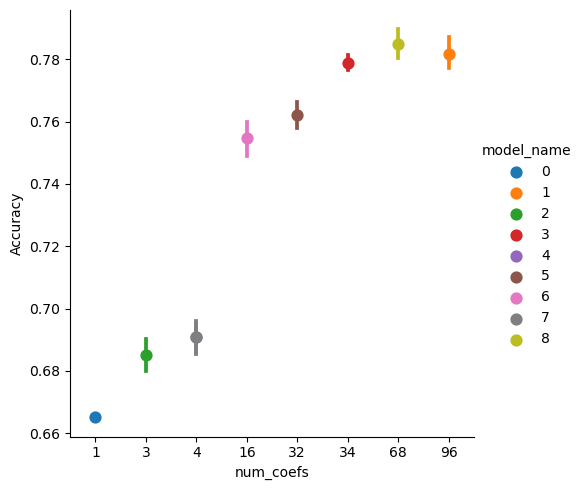

In [121]:
sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
            x='num_coefs', y='Accuracy', kind='point', join=False,
            hue='model_name',
            errorbar=('ci', 68))

plt.show()

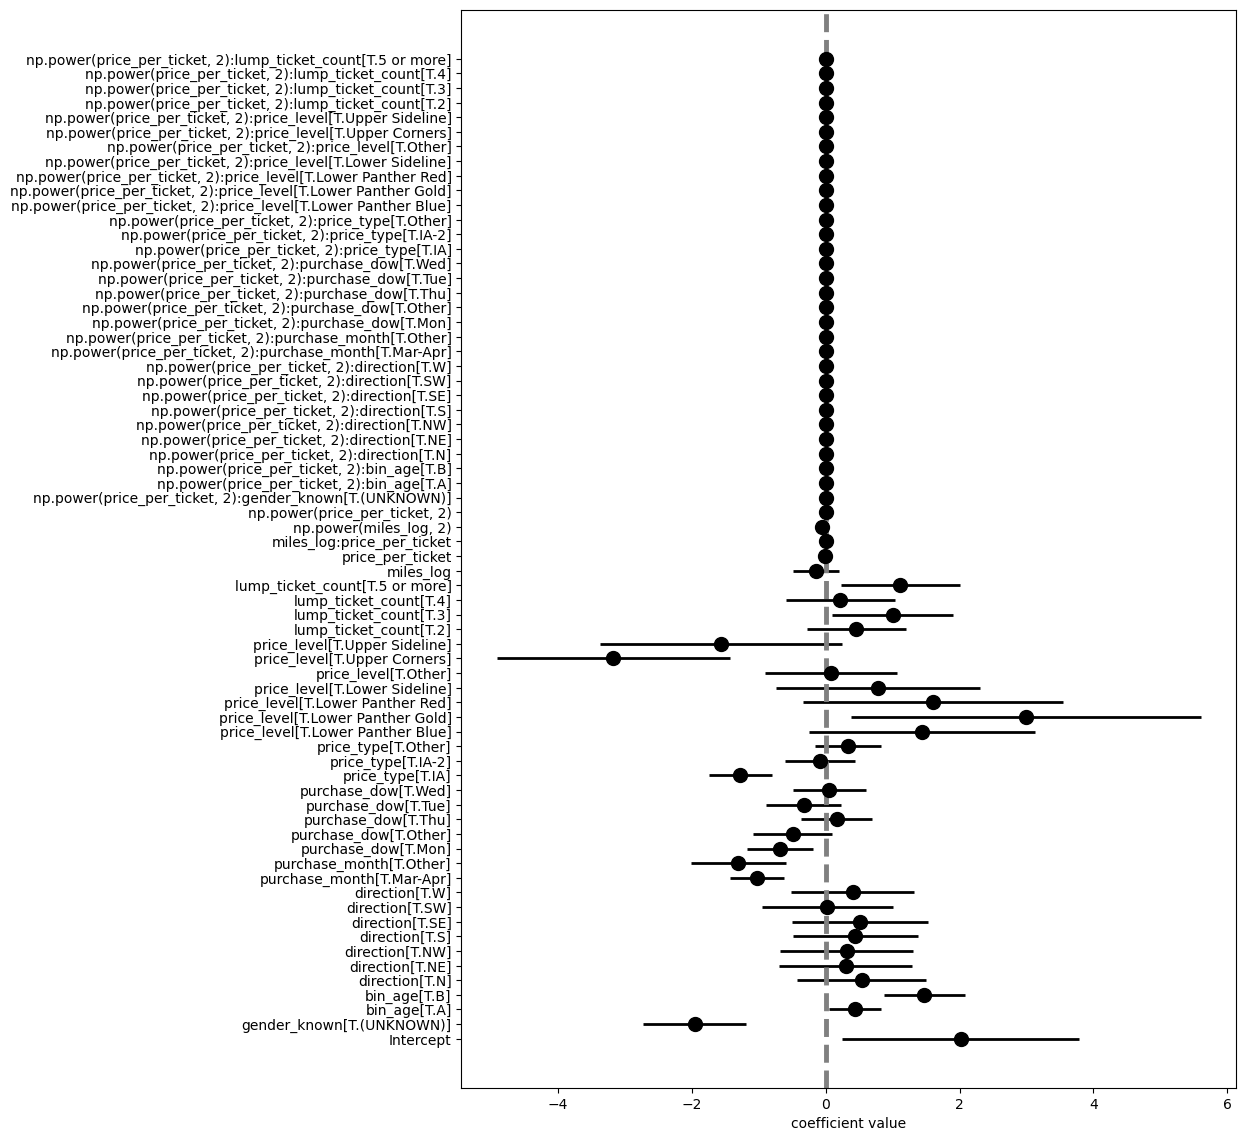

In [122]:
my_coefplot(fit_8)

### Fitting the entire data set

In [123]:
best_model = smf.logit(formula=formula_list[8], data = df_model).fit()
best_model.pvalues < 0.05

Optimization terminated successfully.
         Current function value: 0.450918
         Iterations 8


Intercept                                                        True
gender_known[T.(UNKNOWN)]                                        True
bin_age[T.A]                                                     True
bin_age[T.B]                                                     True
direction[T.N]                                                  False
                                                                ...  
np.power(price_per_ticket, 2):price_level[T.Upper Sideline]     False
np.power(price_per_ticket, 2):lump_ticket_count[T.2]            False
np.power(price_per_ticket, 2):lump_ticket_count[T.3]            False
np.power(price_per_ticket, 2):lump_ticket_count[T.4]            False
np.power(price_per_ticket, 2):lump_ticket_count[T.5 or more]    False
Length: 68, dtype: bool

In [124]:
input_grid_8 = pd.DataFrame([ (gender_known, 
                             bin_age, 
                             direction, 
                             miles_log, 
                             purchase_month,
                             purchase_dow,
                             price_per_ticket,
                             price_type,
                             price_level,
                             lump_ticket_count) 
                             for gender_known in df_model.gender_known.unique()
                             for bin_age in df_model.bin_age.mode()
                             for direction in df_model.direction.mode()
                             for miles_log in np.linspace(df_model.miles_log.min(), df_model.miles_log.max(), num = 101)
                             for purchase_month in df_model.purchase_month.mode()
                             for purchase_dow in df_model.purchase_dow.mode()
                             for price_per_ticket in [df_model.price_per_ticket.mean()]
                             for price_type in df_model.price_type.mode()
                             for price_level in df_model.price_level.unique()
                             for lump_ticket_count in df_model.lump_ticket_count.mode() ],
                          columns=['gender_known','bin_age', 'direction', 'miles_log', 'purchase_month', 'purchase_dow', 'price_per_ticket',
                                  'price_type', 'price_level', 'lump_ticket_count'])

In [125]:
df_viz_8 = input_grid_8.copy()

In [126]:
df_viz_8['pred_prob_8'] = fit_8.predict(input_grid_8)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


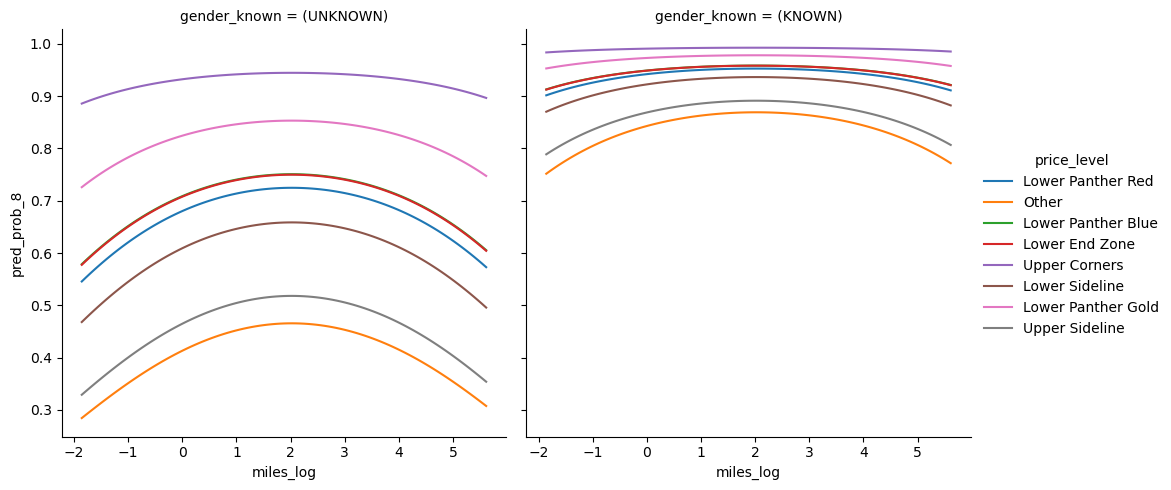

In [127]:
sns.relplot(data = df_viz_8, x='miles_log', y='pred_prob_8', hue='price_level', col='gender_known',
            kind='line', estimator=None, units='price_level')

plt.show()

According to this chart, knowing the gender with model 8 greatly increases the chance of renewal as opposed to unknown

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


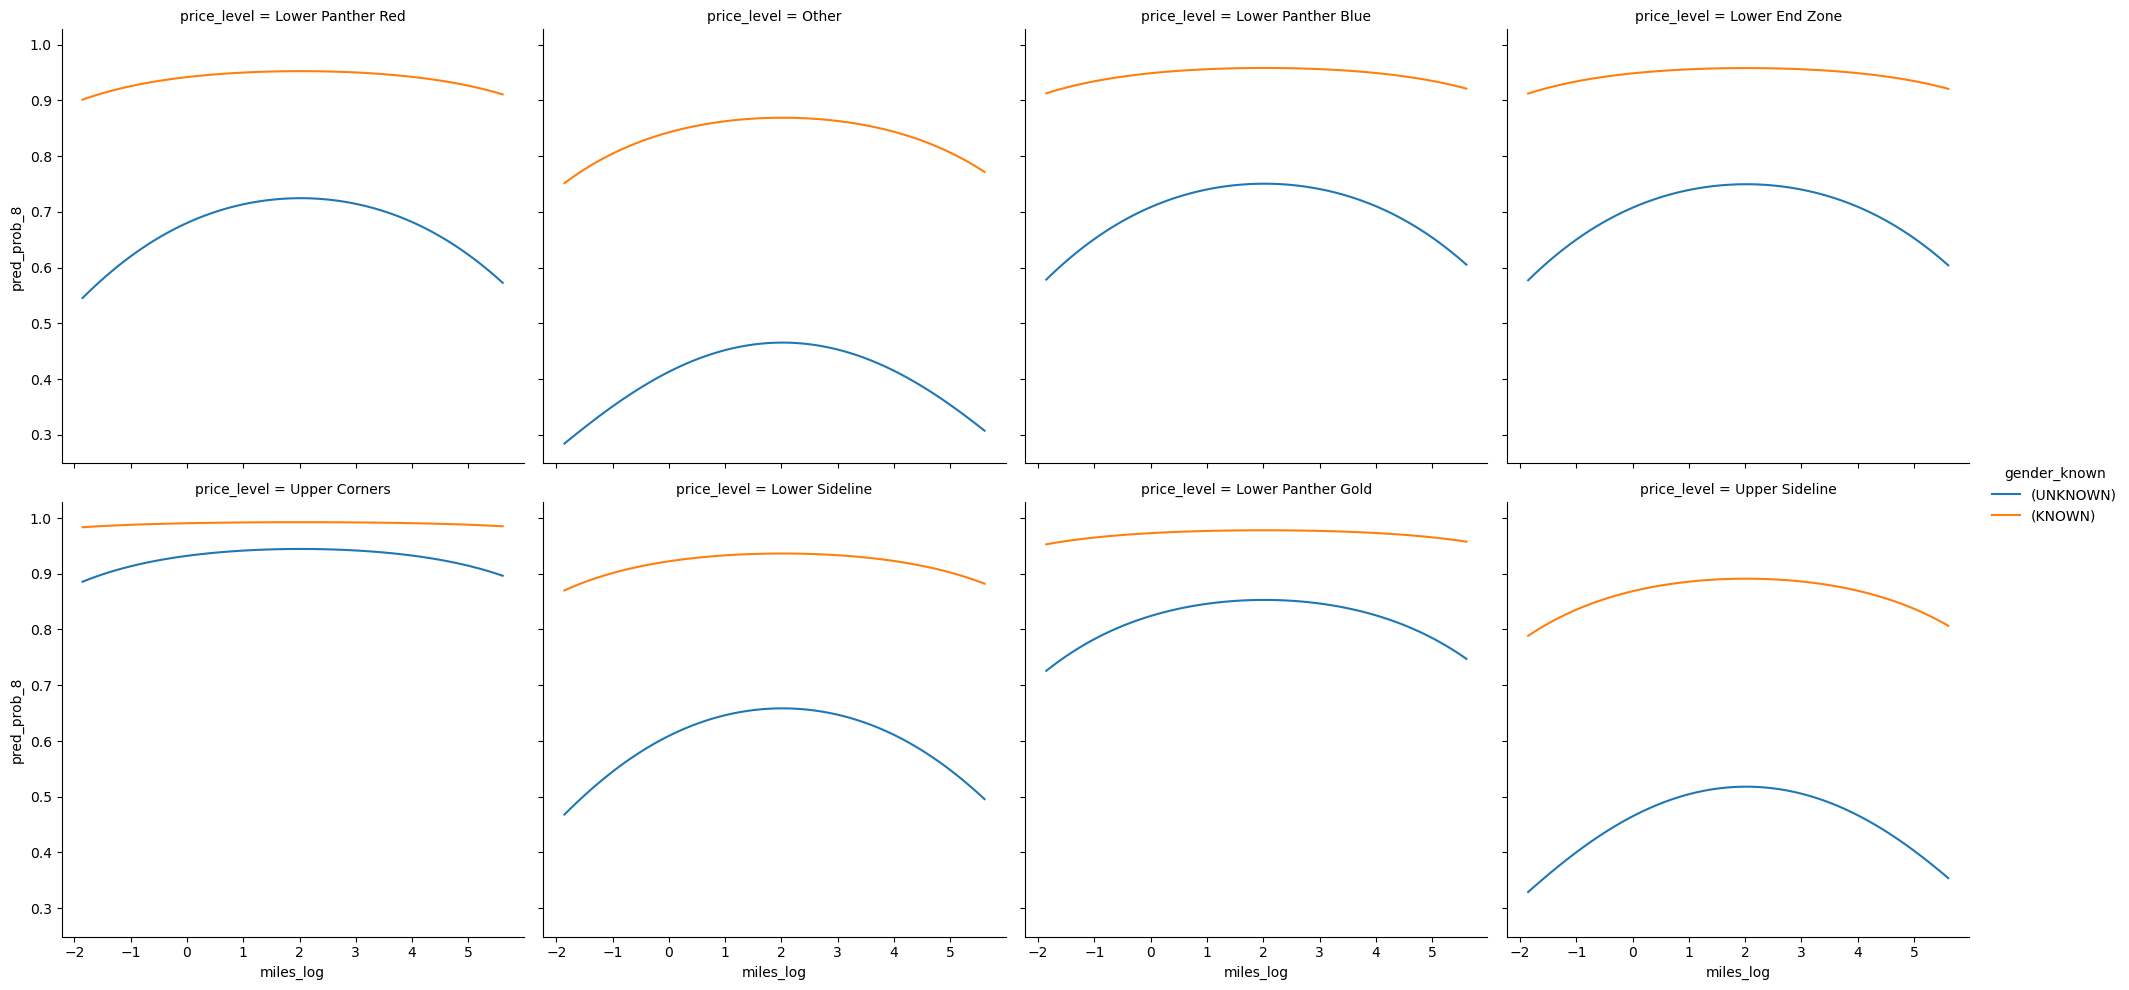

In [128]:
sns.relplot(data = df_viz_8, x='miles_log', y='pred_prob_8', hue='gender_known', col='price_level',
            kind='line', estimator=None, units='gender_known', col_wrap=4)

plt.show()

Again in each instace we see known genders renewing more often than unknown, with a slight curve based on distance